In [220]:
%config InlineBackend.figure_format = 'retina'

In [221]:
from pathlib import Path
import numpy as np
from astropy.io import fits
from matplotlib import pyplot as plt
from kspecdr.inst.isoplane import convert_isoplane_header, add_fiber_table
from kspecdr.io.image import ImageFile
from kspecdr.preproc.make_im import make_im
from kspecdr.tlm.make_tlm import read_instrument_data, make_tlm
from scipy.signal import find_peaks_cwt, find_peaks
from rascal.util import refine_peaks
from matplotlib.lines import Line2D

WD = Path("/data1/hbahk/kspec/kspecdr")
RESOURCES = WD / "resources"
TESTDIR = RESOURCES / "isoplane_arctest_20251224"

In [222]:
hdul = fits.open(TESTDIR / "flat_150_490_1sec 2025-12-24.fits")
hdr = hdul[0].header
# cleaned_hdr = sanitize_header_drop_unparsable(hdr)
new_hdr = convert_isoplane_header(hdr, ndfclass="MFFFF")

# add fiber table
add_fiber_table(hdul, n_fibers=16)

# just use the first frame for now
hdul[0].data = hdul[0].data[0]
# make new fits file with new header and fiber table
new_hdr["NAXIS"] = 2
new_hdr.remove("NAXIS3")
hdul[0].header = new_hdr

new_fpath = TESTDIR / "flat_150_490_1sec_converted.fits"
hdul.writeto(new_fpath, overwrite=True)

In [223]:
hdul.info()

Filename: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/flat_150_490_1sec 2025-12-24.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     188   (1340, 1300)   uint16   
  1  FIBRES        1 BinTableHDU     13   16R x 2C   ['1A', '20A']   


In [224]:
from astropy.table import Table

Table(hdul[1].data)

TYPE,NAME
str1,str20
P,Fiber 1
P,Fiber 2
P,Fiber 3
P,Fiber 4
P,Fiber 5
P,Fiber 6
P,Fiber 7
P,Fiber 8
P,Fiber 9


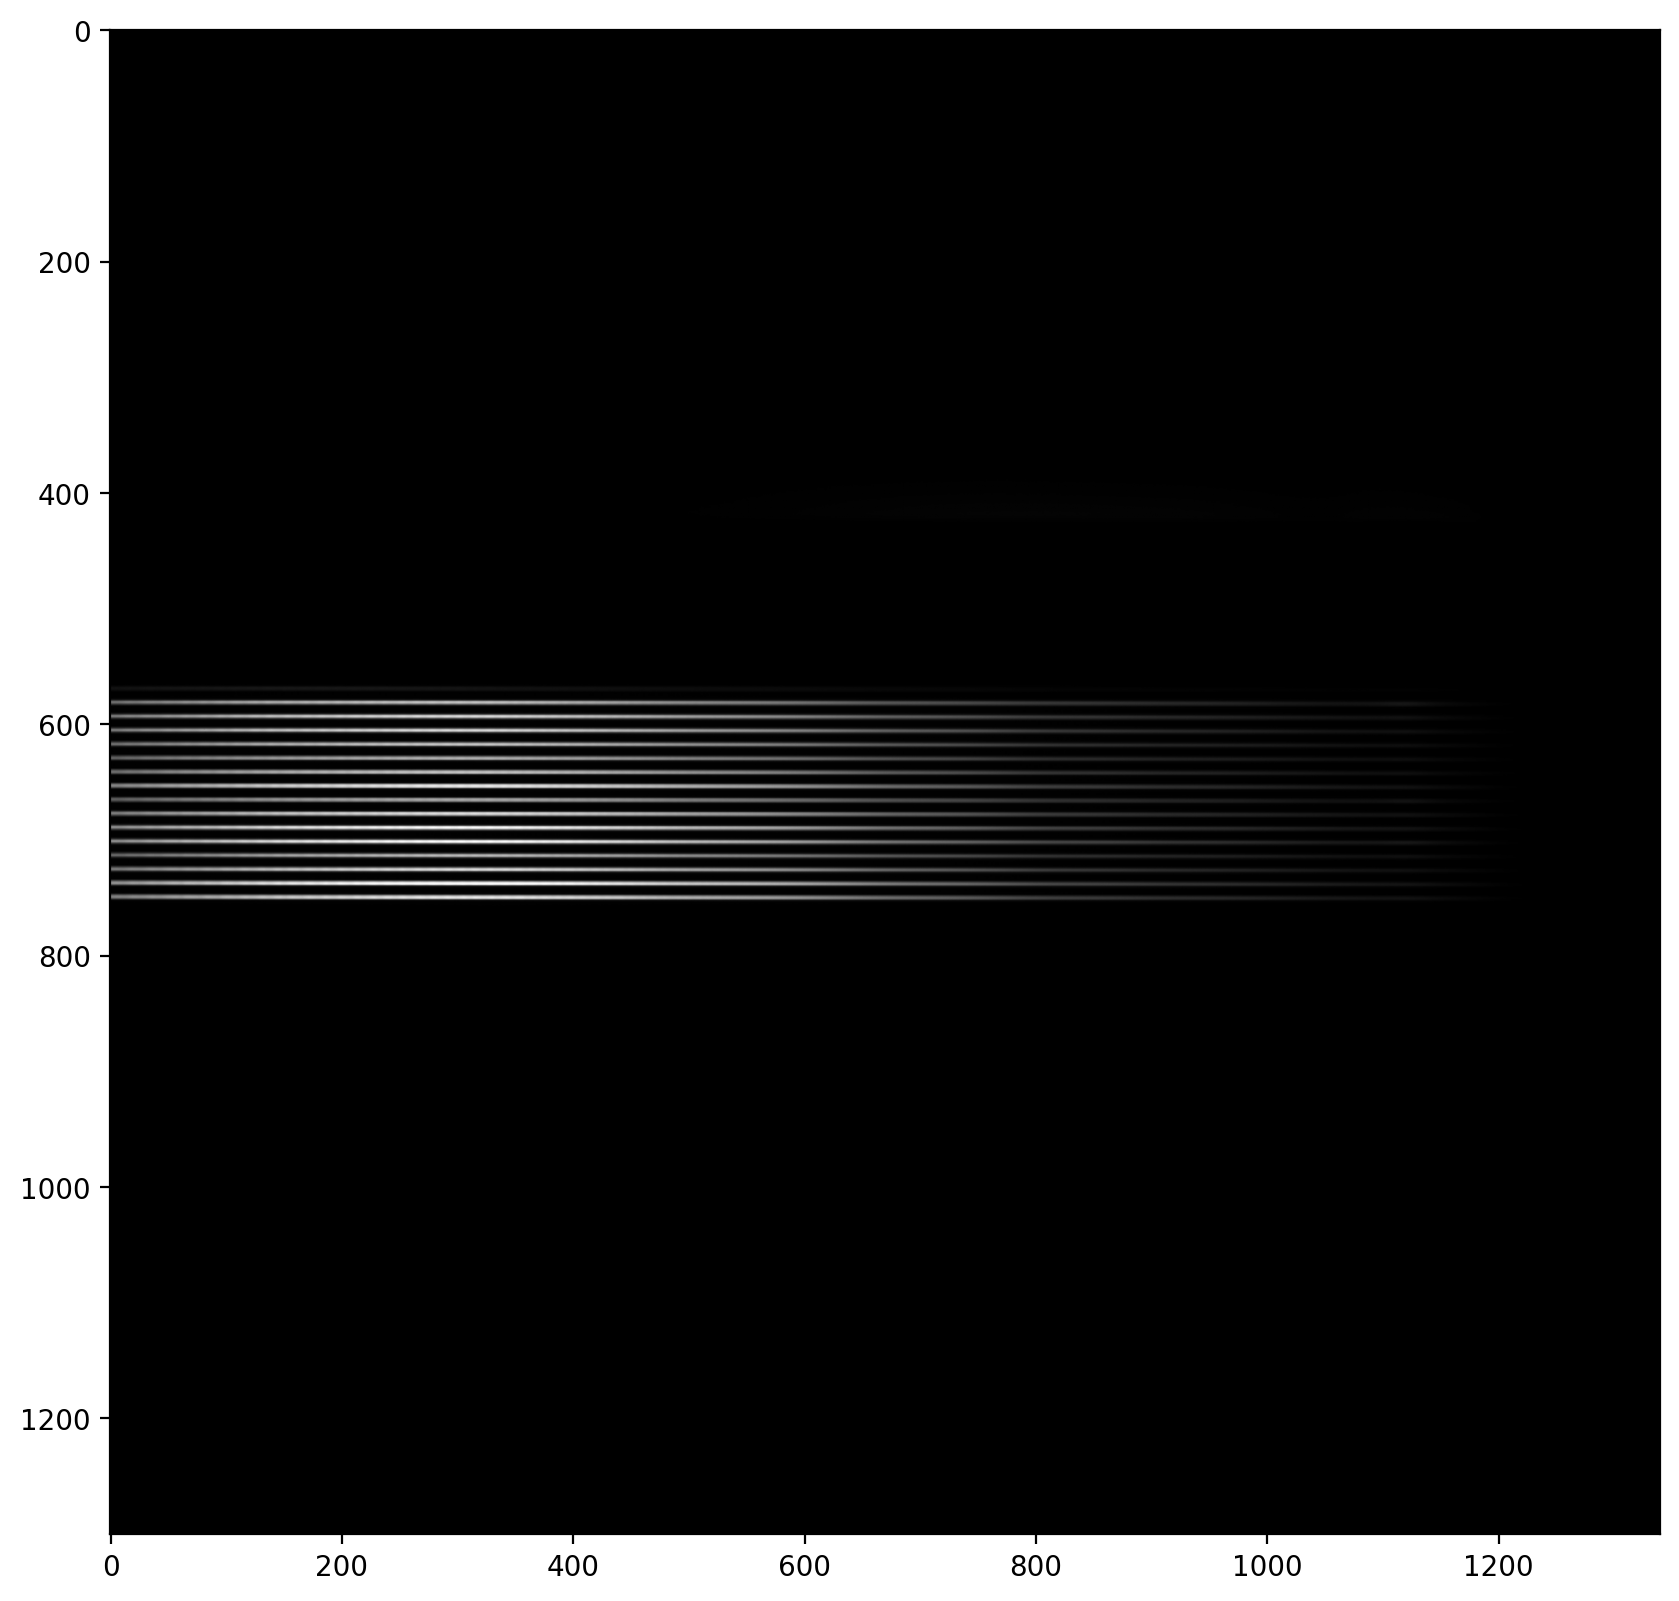

In [225]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.imshow(hdul[0].data, cmap="gray")
plt.show()

In [226]:
args = {"IMAGE_FILENAME": new_fpath.as_posix()}

im = ImageFile(new_fpath.as_posix(), mode='READ')
im.open()


make_im(new_fpath.as_posix(),
        cosmic_ray_method='NONE',
        verbose=False)

INFO:kspecdr.io.image:Opened file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/flat_150_490_1sec_converted.fits (mode: READ)
INFO:kspecdr.preproc.make_im:Creating IM file from raw data with TDFIO_CREATEBYCOPY functionality...
INFO:kspecdr.preproc.make_im:Creating IM file from raw file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/flat_150_490_1sec_converted.fits -> /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/flat_150_490_1sec_converted_im.fits
INFO:kspecdr.io.image:Opened file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/flat_150_490_1sec_converted.fits (mode: READ)
INFO:kspecdr.preproc.make_im:Instrument: ISOPLANE, SPECTID: UNKNOWN, CLASS: , BITPIX: 16
INFO:kspecdr.io.image:Closed file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/flat_150_490_1sec_converted.fits
INFO:kspecdr.io.image:Opened file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/flat_150_490_1sec_converted.fits (

INFO:kspecdr.preproc.make_im:Copying fiber table from source file
INFO:kspecdr.io.image:Opened file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/flat_150_490_1sec_converted_im.fits (mode: UPDATE)
INFO:kspecdr.io.image:Copied fiber table 'FIBRES' from source file
INFO:kspecdr.io.image:Closed file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/flat_150_490_1sec_converted_im.fits
INFO:kspecdr.io.image:Closed file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/flat_150_490_1sec_converted.fits
INFO:kspecdr.preproc.make_im:Successfully created IM file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/flat_150_490_1sec_converted_im.fits
INFO:kspecdr.io.image:Opened file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/flat_150_490_1sec_converted_im.fits (mode: UPDATE)
INFO:kspecdr.preproc.make_im:0.01% of pixels were saturated
INFO:kspecdr.preproc.make_im:No bias subtraction performed
INFO:kspecdr.preproc.make_i

'/data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/flat_150_490_1sec_converted_im.fits'

In [227]:
fpath_im = new_fpath.parent / (new_fpath.stem + "_im.fits")
args = {"IMAGE_FILENAME": fpath_im.as_posix()}

im = ImageFile(fpath_im.as_posix(), mode='READ')
im.open()
img_data, var_data, fibre_types = read_instrument_data(im, 6)

INFO:kspecdr.io.image:Opened file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/flat_150_490_1sec_converted_im.fits (mode: READ)


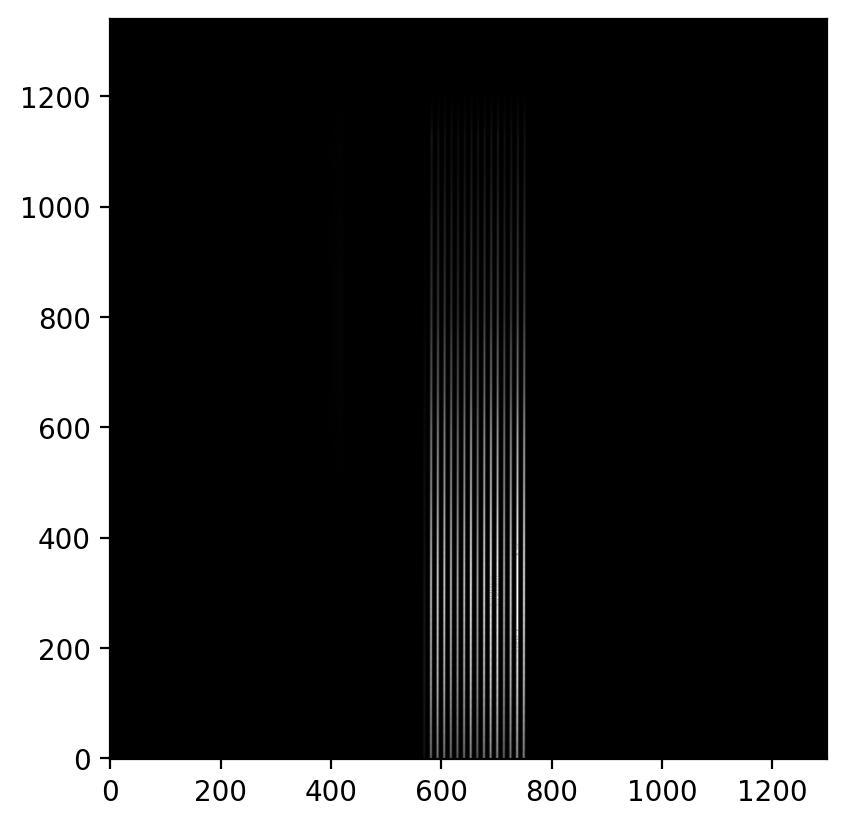

In [228]:
plt.imshow(img_data, cmap='gray', origin='lower')
plt.show()

In [229]:
im.get_instrument_code()

99

In [230]:
make_tlm(args)

INFO:kspecdr.tlm.make_tlm:Generating tramline map from /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/flat_150_490_1sec_converted_im.fits
INFO:kspecdr.io.image:Opened file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/flat_150_490_1sec_converted_im.fits (mode: READ)
INFO:kspecdr.tlm.make_tlm:Instrument code: 99
INFO:kspecdr.tlm.make_tlm:Starting tramline map generation for non-2DF instrument
INFO:kspecdr.tlm.make_tlm:Fibres officially in use: 16
INFO:kspecdr.tlm.make_tlm:Fibres potentially able: 0
INFO:kspecdr.tlm.make_tlm:Fibres officially dead: 0
INFO:kspecdr.tlm.make_tlm:Max number of traces: 16
INFO:kspecdr.tlm.make_tlm:Sweeping image for signs of fibre traces...
INFO:kspecdr.tlm.make_tlm:Processing column 0/1340 (0.0%)
INFO:kspecdr.tlm.make_tlm:Processing column 50/1340 (3.7%)
INFO:kspecdr.tlm.make_tlm:Processing column 100/1340 (7.5%)
INFO:kspecdr.tlm.make_tlm:Processing column 150/1340 (11.2%)
INFO:kspecdr.tlm.make_tlm:Processing column 200/1340

INFO:kspecdr.tlm.make_tlm:Final number of traces: 16
INFO:kspecdr.tlm.make_tlm:Found 16 traces across the image
INFO:kspecdr.tlm.make_tlm:Matching traces to fibres
INFO:kspecdr.tlm.make_tlm:Converted traces to tramline map (0 missing fibres)
INFO:kspecdr.tlm.make_tlm:Interpolating missing fibre traces
INFO:kspecdr.tlm.make_tlm:Writing tramline data to /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/flat_150_490_1sec_converted_tlm.fits
INFO:kspecdr.tlm.make_tlm:Predicting wavelength data
INFO:kspecdr.tlm.make_tlm:Writing wavelength data
INFO:kspecdr.tlm.make_tlm:Tramline map generation completed
INFO:kspecdr.tlm.make_tlm:Generated tramline map: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/flat_150_490_1sec_converted_tlm.fits
INFO:kspecdr.io.image:Closed file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/flat_150_490_1sec_converted_im.fits


In [231]:
fpath_tlm = new_fpath.parent / (new_fpath.stem + "_tlm.fits")

tlm = ImageFile(fpath_tlm.as_posix(), mode='READ')
tlm.open()
print(tlm.get_size())

hdul = fits.open(fpath_tlm)
tlm_data = hdul[0].data
print(tlm_data.shape)
hdul.info()

INFO:kspecdr.io.image:Opened file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/flat_150_490_1sec_converted_tlm.fits (mode: READ)
(1340, 16)
(16, 1340)
Filename: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/flat_150_490_1sec_converted_tlm.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       9   (1340, 16)   float64   
  1  WAVELA        1 ImageHDU         8   (1340, 16)   float64   


In [232]:
img_data.shape

(1340, 1300)

In [233]:
tlm_data

array([[567.69401709, 567.69628484, 567.69855072, ..., 569.06654125,
        569.06632479, 569.06610647],
       [580.21245421, 580.21375443, 580.21505485, ..., 582.12532737,
        582.12688879, 582.1284504 ],
       [593.05860806, 593.05776264, 593.05692015, ..., 594.5454696 ,
        594.54854212, 594.55161758],
       ...,
       [724.94505495, 724.94492894, 724.94480488, ..., 726.52137631,
        726.52386227, 726.52635018],
       [736.88583639, 736.88612582, 736.88641661, ..., 738.47236074,
        738.47444591, 738.47653242],
       [748.7039072 , 748.70587418, 748.7078398 , ..., 750.13420336,
        750.1343746 , 750.13454451]], shape=(16, 1340), dtype='>f8')

(0.0, 300.0)

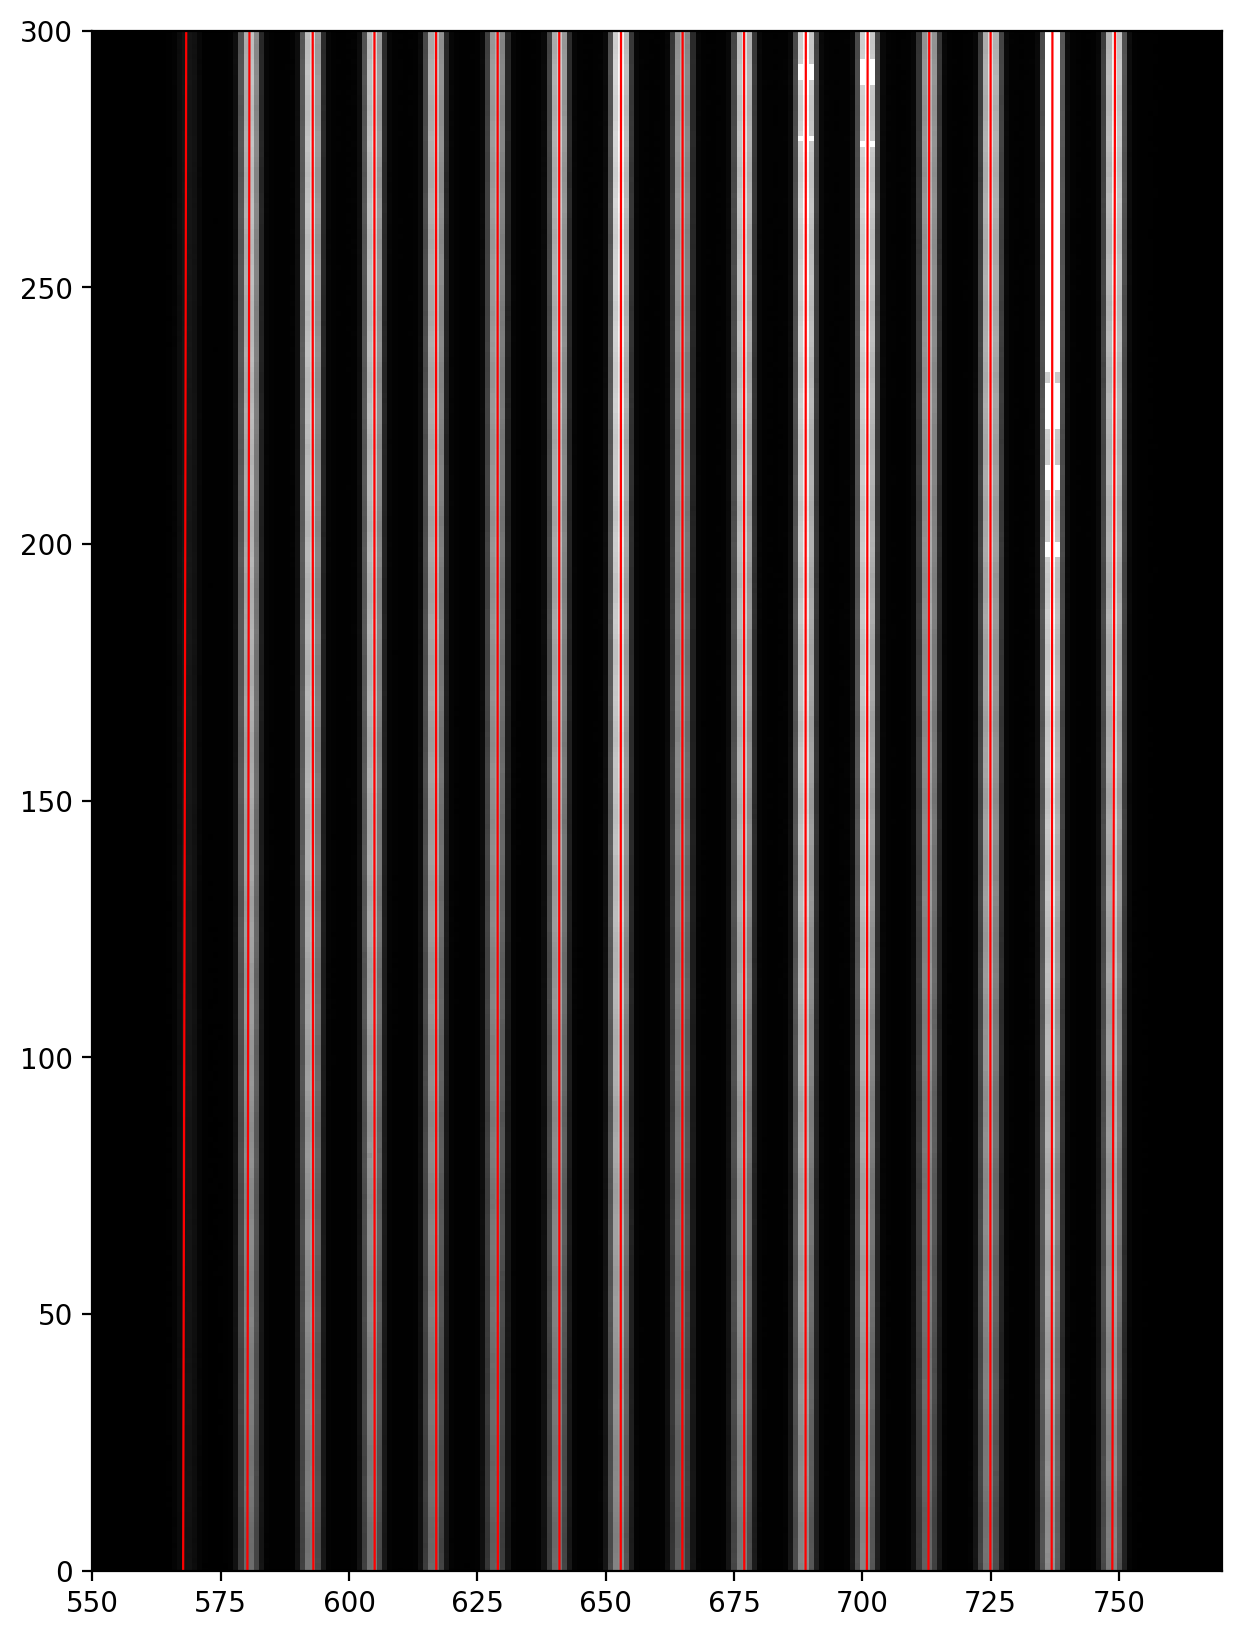

In [234]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.imshow(img_data, cmap='gray', origin='lower')
for tl in tlm_data:
    ax.plot(tl, np.arange(tl.shape[0]), c="r", lw=0.8)

ax.set_xlim(550, 770)
ax.set_ylim(0, 300)
# ax.set_ylim(1000, 1200)


In [235]:
from kspecdr.extract.make_ex import make_ex
fpath_ex = new_fpath.parent / (new_fpath.stem + "_ex.fits")

args["EXTRAC_FILENAME"] = fpath_ex.as_posix()
args["TLMAP_FILENAME"] = fpath_tlm.as_posix()

make_ex(args)

hdul = fits.open(fpath_ex)

INFO:kspecdr.extract.make_ex:Extracting /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/flat_150_490_1sec_converted_im.fits -> /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/flat_150_490_1sec_converted_ex.fits using TLM /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/flat_150_490_1sec_converted_tlm.fits
INFO:kspecdr.extract.make_ex:Extraction Method: TRAM
INFO:kspecdr.io.image:Opened file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/flat_150_490_1sec_converted_im.fits (mode: READ)
INFO:kspecdr.io.image:Opened file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/flat_150_490_1sec_converted_tlm.fits (mode: READ)
INFO:kspecdr.io.image:Closed file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/flat_150_490_1sec_converted_tlm.fits
INFO:kspecdr.io.image:Closed file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/flat_150_490_1sec_converted_im.fits
INFO:kspecdr.extract.make_ex:Per

INFO:kspecdr.extract.make_ex:Written extracted file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/flat_150_490_1sec_converted_ex.fits


Filename: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/flat_150_490_1sec_converted_ex.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     196   (1340, 16)   float32   
  1  VARIANCE      1 ImageHDU         8   (1340, 16)   float32   
  2  WAVELA        1 ImageHDU         8   (1340, 16)   float32   


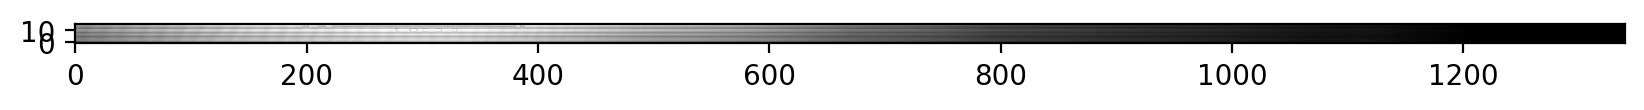

In [236]:
hdul = fits.open(fpath_ex)
hdul.info()

flat_ex = hdul[0].data

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.imshow(flat_ex, cmap='gray', origin='lower')
plt.show()

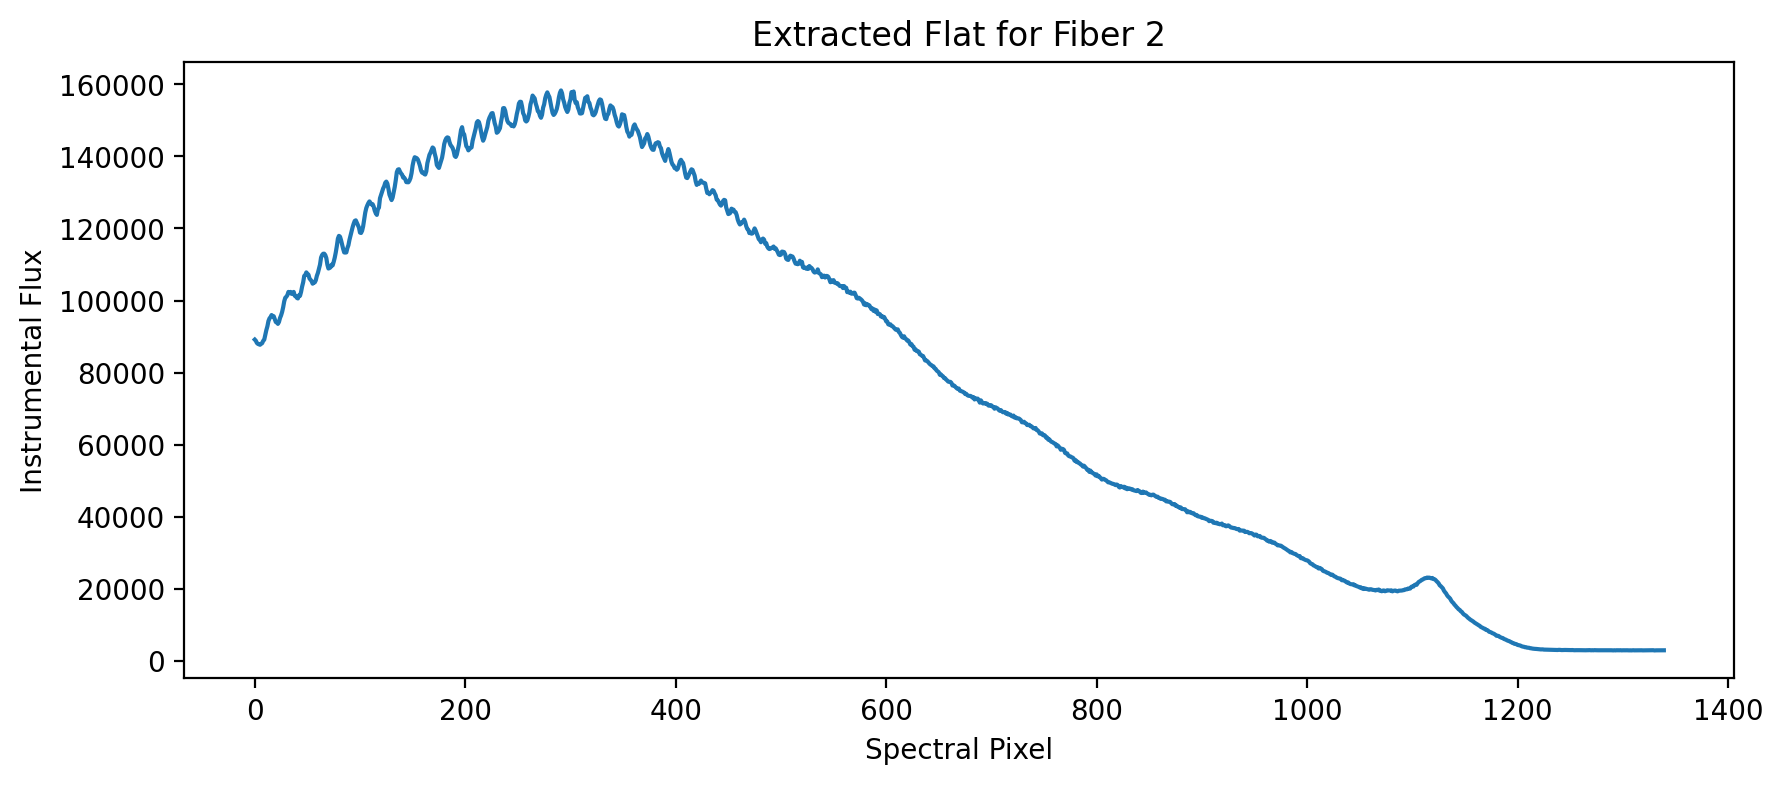

In [237]:
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(111)
ax.plot(flat_ex[1])
ax.set_ylabel("Instrumental Flux")
ax.set_xlabel("Spectral Pixel")
ax.set_title("Extracted Flat for Fiber 2")
plt.show()


In [238]:
fpath = TESTDIR / r"Hg_paper_150_620_1sec 2025-12-24 12_09_50.fits"
hdul = fits.open(fpath)
hdr = hdul[0].header
# cleaned_hdr = sanitize_header_drop_unparsable(hdr)
new_hdr = convert_isoplane_header(hdr, ndfclass="MFARC")

# add fiber table
add_fiber_table(hdul, n_fibers=16)

# just use the first frame for now
hdul[0].data = hdul[0].data[0]
# make new fits file with new header and fiber table
new_hdr["NAXIS"] = 2
new_hdr.remove("NAXIS3")
hdul[0].header = new_hdr

new_fpath = TESTDIR / "Hg_150_620_converted.fits"
hdul.writeto(new_fpath, overwrite=True)

make_im(new_fpath.as_posix(),
        cosmic_ray_method='NONE',
        verbose=False)

fpath_im = new_fpath.parent / (new_fpath.stem + "_im.fits")
fpath_ex = new_fpath.parent / (new_fpath.stem + "_ex.fits")
args = {"IMAGE_FILENAME": fpath_im.as_posix(),
        "EXTRAC_FILENAME": fpath_ex.as_posix(),
        "TLMAP_FILENAME": fpath_tlm.as_posix(),}

make_ex(args)

INFO:kspecdr.preproc.make_im:Creating IM file from raw data with TDFIO_CREATEBYCOPY functionality...
INFO:kspecdr.preproc.make_im:Creating IM file from raw file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/Hg_150_620_converted.fits -> /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/Hg_150_620_converted_im.fits
INFO:kspecdr.io.image:Opened file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/Hg_150_620_converted.fits (mode: READ)
INFO:kspecdr.preproc.make_im:Instrument: ISOPLANE, SPECTID: UNKNOWN, CLASS: , BITPIX: 16
INFO:kspecdr.io.image:Closed file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/Hg_150_620_converted.fits
INFO:kspecdr.io.image:Opened file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/Hg_150_620_converted.fits (mode: READ)
INFO:kspecdr.preproc.make_im:Creating variance HDU for raw file


INFO:kspecdr.preproc.make_im:Copying fiber table from source file
INFO:kspecdr.io.image:Opened file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/Hg_150_620_converted_im.fits (mode: UPDATE)
INFO:kspecdr.io.image:Copied fiber table 'FIBRES' from source file
INFO:kspecdr.io.image:Closed file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/Hg_150_620_converted_im.fits
INFO:kspecdr.io.image:Closed file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/Hg_150_620_converted.fits
INFO:kspecdr.preproc.make_im:Successfully created IM file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/Hg_150_620_converted_im.fits
INFO:kspecdr.io.image:Opened file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/Hg_150_620_converted_im.fits (mode: UPDATE)
INFO:kspecdr.preproc.make_im:0.00% of pixels were saturated
INFO:kspecdr.preproc.make_im:No bias subtraction performed
INFO:kspecdr.preproc.make_im:Variance HDU created and initiali

Filename: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/Hg_150_620_converted_ex.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     171   (1340, 16)   float32   
  1  VARIANCE      1 ImageHDU         8   (1340, 16)   float32   
  2  WAVELA        1 ImageHDU         8   (1340, 16)   float32   


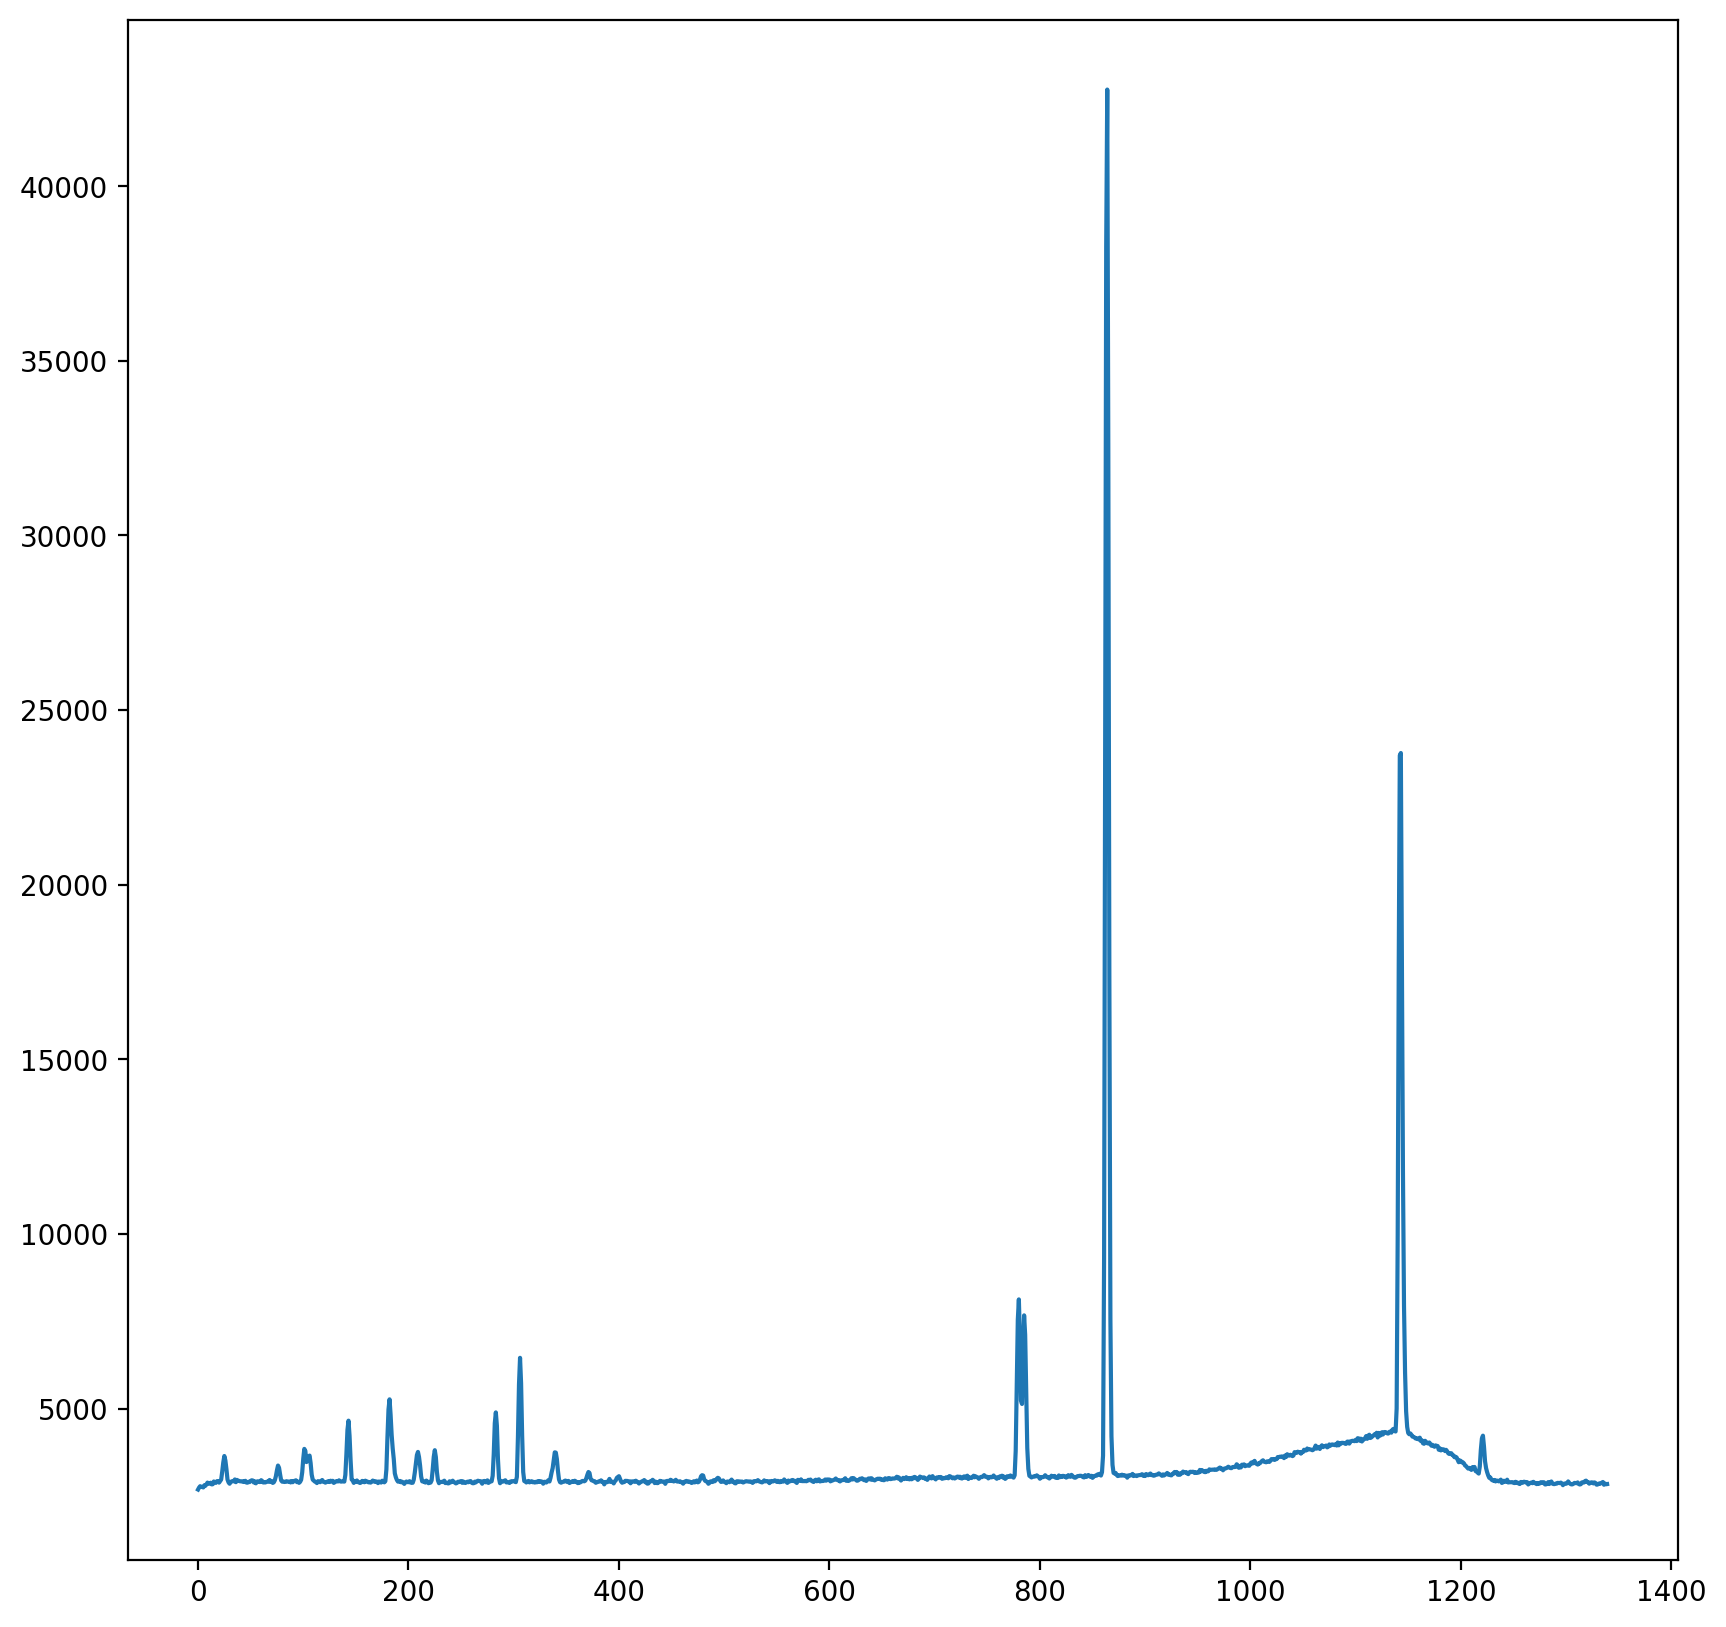

In [239]:
new_fpath = TESTDIR / "Hg_150_620_converted.fits"
fpath_im = new_fpath.parent / (new_fpath.stem + "_im.fits")
fpath_ex = new_fpath.parent / (new_fpath.stem + "_ex.fits")

hdul = fits.open(fpath_ex)
hdul.info()
fibs = np.array([1, 2, 12, 13, 15, 16])
ifibs = fibs - 1
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
# ax.imshow(hdul[0].data, cmap='gray', origin='lower')
# ax.set_xlim(800, 900)
ax.plot(hdul[0].data[ifibs[0]])
plt.show()

hg_f1 = hdul[0].data[0][::-1]

In [240]:
fpath = TESTDIR / r"intellical_hg_150_620_f1 2025-12-24.fits"
hdul = fits.open(fpath)
hdr = hdul[0].header
# cleaned_hdr = sanitize_header_drop_unparsable(hdr)
new_hdr = convert_isoplane_header(hdr, ndfclass="MFFFF")

# add fiber table
add_fiber_table(hdul, n_fibers=16)

# just use the first frame for now
hdul[0].data = hdul[0].data[0]
# make new fits file with new header and fiber table
new_hdr["NAXIS"] = 2
new_hdr.remove("NAXIS3")
hdul[0].header = new_hdr

new_fpath = TESTDIR / "intellical_hg_150_620_f1_converted.fits"
hdul.writeto(new_fpath, overwrite=True)

make_im(new_fpath.as_posix(),
        cosmic_ray_method='NONE',
        verbose=False)

fpath_im = new_fpath.parent / (new_fpath.stem + "_im.fits")
fpath_ex = new_fpath.parent / (new_fpath.stem + "_ex.fits")
args = {"IMAGE_FILENAME": fpath_im.as_posix(),
        "EXTRAC_FILENAME": fpath_ex.as_posix(),
        "TLMAP_FILENAME": fpath_tlm.as_posix(),}

make_ex(args)

INFO:kspecdr.preproc.make_im:Creating IM file from raw data with TDFIO_CREATEBYCOPY functionality...
INFO:kspecdr.preproc.make_im:Creating IM file from raw file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/intellical_hg_150_620_f1_converted.fits -> /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/intellical_hg_150_620_f1_converted_im.fits
INFO:kspecdr.io.image:Opened file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/intellical_hg_150_620_f1_converted.fits (mode: READ)
INFO:kspecdr.preproc.make_im:Instrument: ISOPLANE, SPECTID: UNKNOWN, CLASS: , BITPIX: 16
INFO:kspecdr.io.image:Closed file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/intellical_hg_150_620_f1_converted.fits
INFO:kspecdr.io.image:Opened file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/intellical_hg_150_620_f1_converted.fits (mode: READ)
INFO:kspecdr.preproc.make_im:Creating variance HDU for raw file
INFO:kspecdr.preproc.make_im:Copy

Filename: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/intellical_hg_150_620_f1_converted_ex.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     205   (1340, 16)   float32   
  1  VARIANCE      1 ImageHDU         8   (1340, 16)   float32   
  2  WAVELA        1 ImageHDU         8   (1340, 16)   float32   


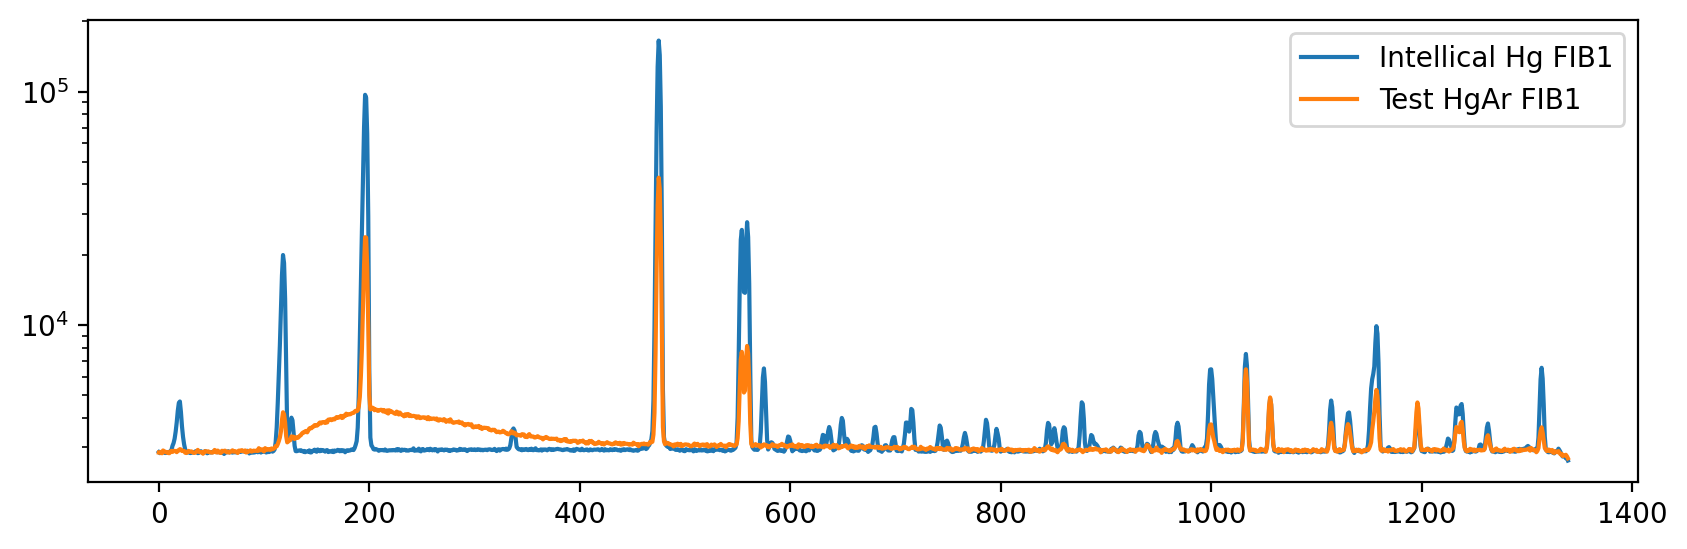

In [241]:
new_fpath = TESTDIR / "intellical_hg_150_620_f1_converted.fits"
fpath_im = new_fpath.parent / (new_fpath.stem + "_im.fits")
fpath_ex = new_fpath.parent / (new_fpath.stem + "_ex.fits")

hdul = fits.open(fpath_ex)
hdul.info()
tlm_hdul = fits.open(fpath_tlm)
wavela = tlm_hdul[1].data[0]

intellical_hg_f1 = hdul[0].data[0][::-1]

fig = plt.figure(figsize=(10, 3))
ax = fig.add_subplot(111)
# ax.imshow(hdul[0].data, cmap='gray', origin='lower')
# ax.set_xlim(800, 900)
ax.plot(intellical_hg_f1, label="Intellical Hg FIB1")
ax.plot(hg_f1, label="Test HgAr FIB1")
ax.set_yscale("log")
ax.legend()
plt.show()

In [242]:
%matplotlib inline

In [243]:
newport_oriel = Table.read(RESOURCES / "spectral_atlas" / "newport-oriel.csv")
newport_hgar = newport_oriel[newport_oriel["Model No."] == 6035]
newport_ar = newport_oriel[newport_oriel["Model No."] == 6030]
newport_ne = newport_oriel[newport_oriel["Model No."] == 6032]

In [244]:
nx = len(intellical_hg_f1)
midpix = 0.5 * nx
dispers = 3.68
lambdac = 6200
dist_from_midpix = np.linspace(0.5, nx + 0.5, nx) - midpix
wavevec = (lambdac + dispers * dist_from_midpix) * 0.1  # convert to nm
wavelength_data = wavevec.reshape(nx, 1).repeat(16, axis=1)

In [245]:
wavevec

array([373.624     , 373.99227483, 374.36054966, ..., 866.00745034,
       866.37572517, 866.744     ], shape=(1340,))

In [246]:
pix2lam

array([3734.4 , 3738.08, 3741.76, ..., 8654.56, 8658.24, 8661.92],
      shape=(1340,))

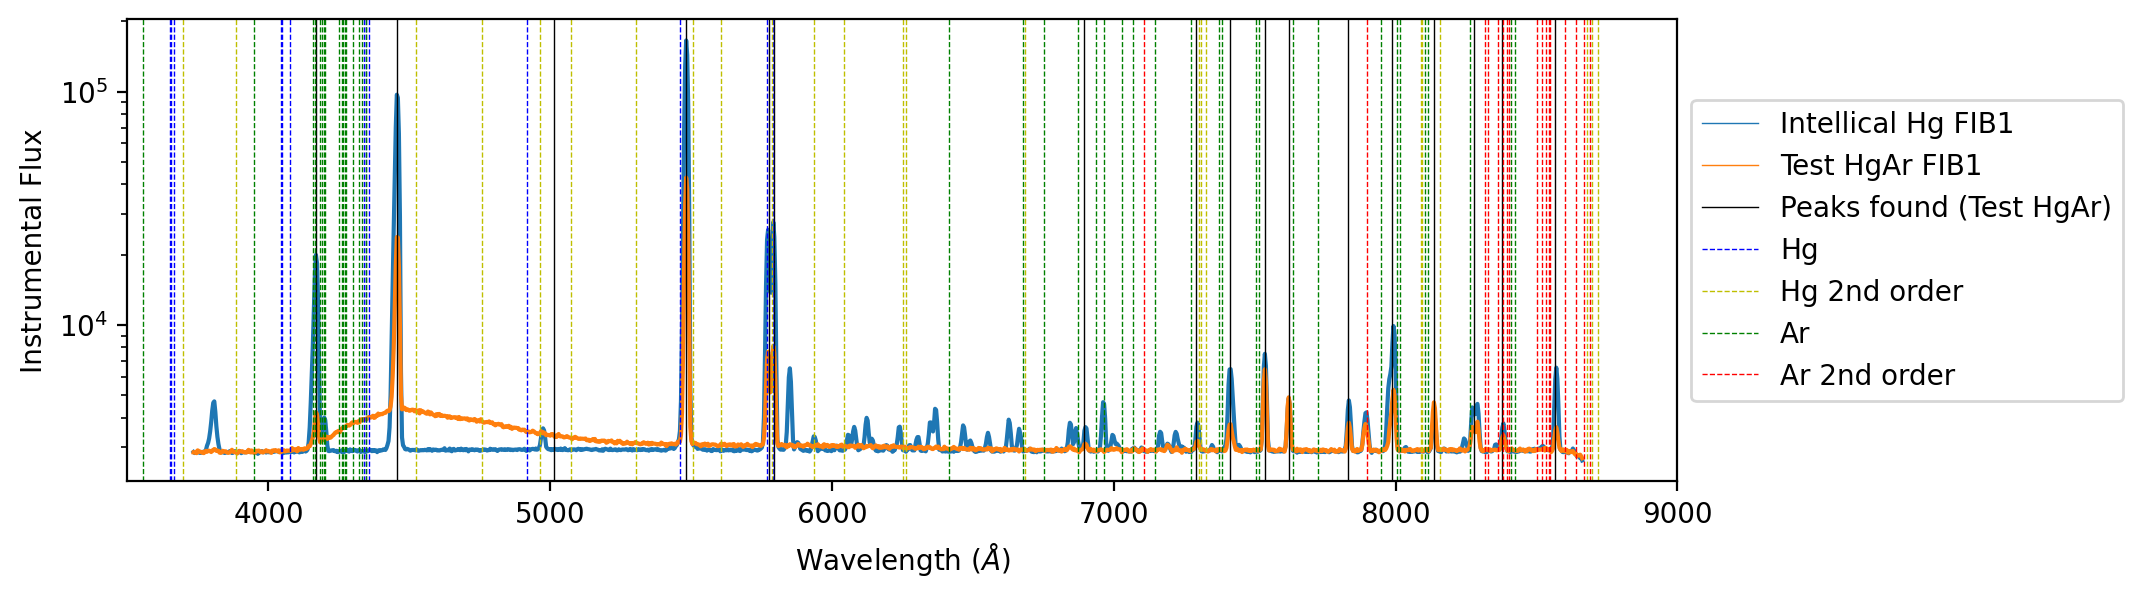

In [247]:
pixel = np.arange(len(intellical_hg_f1))
pix2lam = (pixel - len(pixel)/2)*3.68 + 6200

peaks = find_peaks_cwt(hg_f1, widths=1, min_snr=2)
# peaks, _ = find_peaks(intellical_hg_f1, height=3000, width=(0, 15), prominence=500)

peaks = refine_peaks(hg_f1, peaks, window_width=5)

fig = plt.figure(figsize=(10, 3))
ax = fig.add_subplot(111)
# ax.imshow(hdul[0].data, cmap='gray', origin='lower')
# ax.set_xlim(800, 900)
ax.plot(pix2lam, intellical_hg_f1, label="Intellical Hg FIB1")
ax.plot(pix2lam, hg_f1, label="Test HgAr FIB1")
for p in peaks:
    ax.axvline(pix2lam[int(p)], color="k", lw=0.5)
    
for line in newport_hgar["Wavelength (nm)"]:
    ax.axvline(line*10, color="b", lw=0.5, ls="--")
for line in newport_hgar["Wavelength (nm)"]:
    ax.axvline(line*20, color="y", lw=0.5, ls="--")
    
for line in newport_ar["Wavelength (nm)"]:
    ax.axvline(line*10, color="g", lw=0.5, ls="--")
for line in newport_ar["Wavelength (nm)"]:
    ax.axvline(line*20, color="r", lw=0.5, ls="--")
    
# patch to legend for axvlines to avoid duplicate legend entries
legend_lines = [
    Line2D([0], [0], color="tab:blue", lw=0.5, label="Intellical Hg FIB1"),
    Line2D([0], [0], color="tab:orange", lw=0.5, label="Test HgAr FIB1"),
    Line2D([0], [0], color="k", lw=0.5, label="Peaks found (Test HgAr)"),
    Line2D([0], [0], color="b", lw=0.5, ls="--", label="Hg"),
    Line2D([0], [0], color="y", lw=0.5, ls="--", label="Hg 2nd order"),
          Line2D([0], [0], color="g", lw=0.5, ls="--", label="Ar"),
          Line2D([0], [0], color="r", lw=0.5, ls="--", label="Ar 2nd order")]
ax.legend(handles=legend_lines, loc='center left', bbox_to_anchor=(1, 0.5))

ax.set_yscale("log")
ax.set_xlim(3500, 9000)
ax.set_xlabel(r"Wavelength ($\AA$)")
ax.set_ylabel("Instrumental Flux")
plt.show()

In [248]:
import numpy as np
import plotly.graph_objects as go

def to_native_float(a):
    a = np.asarray(a)

    if a.dtype.byteorder not in ("=", "|"):
        a = a.byteswap().view(a.dtype.newbyteorder("="))

    return np.ascontiguousarray(a, dtype=np.float64)

# Convert arrays for Plotly (native endian)
x = to_native_float(pix2lam)
y1 = to_native_float(intellical_hg_f1)
y2 = to_native_float(hg_f1)

fig = go.Figure()
# fig.add_trace(go.Scatter(x=x, y=y1, mode="lines", name="Intellical Hg FIB1"))
fig.add_trace(go.Scatter(x=x, y=y2, mode="lines", name="Test HgAr FIB1"))

# for p in peaks:
#     fig.add_vline(x=float(x[int(p)]), line_width=0.5, line_color="black")

# for line in newport_hgar["Wavelength (nm)"]:
#     fig.add_vline(x=float(line) * 10.0, line_width=0.5, line_dash="dash", line_color="red", name="Hg")

ymin = np.nanmin(y1[y1 > 0])
ymax = np.nanmax(y1)

for p in peaks:
    xp = float(x[int(p)])

    fig.add_trace(
        go.Scatter(
            x=[xp, xp],
            y=[ymin, ymax],
            mode="lines",
            line=dict(color="black", width=0.5, dash="dash"),
            hovertemplate=(
                "Peak<br>"
                f"pixel = {p:.2f}<br>"
                "λ = %{x:.2f}<br>"
                "<extra></extra>"
            ),
            showlegend=False
        )
    )

for line in newport_hgar["Wavelength (nm)"]:
    lam = float(line) * 10.0
    fig.add_trace(
        go.Scatter(
            x=[lam, lam],
            y=[ymin, ymax],
            mode="lines",
            line=dict(color="red", width=0.5),
            hovertemplate=(
                "Hg line<br>"
                "λ = %{x:.2f}<br>"
                "<extra></extra>"
            ),
            showlegend=False
        )
    )
for line in newport_hgar["Wavelength (nm)"]:
    lam = float(line) * 10.0 * 3
    fig.add_trace(
        go.Scatter(
            x=[lam, lam],
            y=[ymin, ymax],
            mode="lines",
            line=dict(color="yellow", width=0.5),
            hovertemplate=(
                "Hg 3rd line<br>"
                "λ = %{x:.2f}<br>"
                "<extra></extra>"
            ),
            showlegend=False
        )
    )

for line in newport_ar["Wavelength (nm)"]:
    lam = float(line) * 10.0
    fig.add_trace(
        go.Scatter(
            x=[lam, lam],
            y=[ymin, ymax],
            mode="lines",
            line=dict(color="green", width=0.5),
            hovertemplate=(
                "Ar line<br>"
                "λ = %{x:.2f}<br>"
                "<extra></extra>"
            ),
            showlegend=False
        )
    )

fig.update_layout(
    width=1000,
    height=300,
    yaxis_type="log",
    xaxis_range=[3500, 9000],
    margin=dict(l=60, r=20, t=40, b=40),
    legend=dict(orientation="h", y=1.02, x=1, xanchor="right", yanchor="bottom"),
)

fig.show()

In [249]:
user_hg = [3650.20, 3654.80, 3663.30, 4044.40, 4046.60, 4077.80, 4339.20, 4347.50, 4358.40, 5460.70, 5769.60, 5790.70]
user_ar = [7272.90, 7372.10, 7384.00, 7503.90, 7514.60, 7635.1, 7948.2, 8006.20, 8014.80, 8103.70, 8115.30, 8264.5,]

In [250]:
user_pks_hg = [118.34, 196.35, 475.19, 555.1, 560.34, ]
user_atl_hg = [4045., 4347.5, 5460.7, 5769.6, 5790.7, ]

In [251]:
# from rascal.calibrator import Calibrator

# c = Calibrator(peaks, hg_f1)

# c.set_hough_properties(
#     num_slopes=5000,
#     range_tolerance=500.0,
#     xbins=200,
#     ybins=200,
#     min_wavelength=3500.0,
#     max_wavelength=9500.0,
#     linearity_tolerance=50.0,
# )
# c.set_ransac_properties(sample_size=5, top_n_candidate=5)

# c.plot_arc(log_spectrum=True)

In [252]:
# from rascal.atlas import Atlas

# arclines_hg = newport_hgar["Wavelength (nm)"].data * 10
# arclines_ar = newport_ar["Wavelength (nm)"].data * 10

# arclines = np.concatenate([arclines_hg, arclines_ar])
# # arclines = arclines_hg
# elements = ["Hg"] * len(arclines_hg) + ["Ar"] * len(arclines_ar)
# # elements = ["Hg"] * len(arclines_hg)

# arclines = user_hg + user_ar
# elements = ["Hg"] * len(user_hg) + ["Ar"] * len(user_ar)

# atlas = Atlas(
#     min_atlas_wavelength=3500.0,
#     max_atlas_wavelength=9500.0,
#     min_intensity=0.0,
# )
# atlas.add_user_atlas(
#     elements=elements,
#     wavelengths=arclines,
# )

# c.set_atlas(atlas)

# c.do_hough_transform()

# fit_result = c.fit(max_tries=500, fit_deg=2)
# (
#     fit_coeff,
#     matched_peaks,
#     matched_atlas,
#     rms,
#     residual,
#     peak_utilisation,
#     atlas_utilisation,
# ) = fit_result

In [253]:
fpath = TESTDIR / r"Ne_150_620_0.fits"
hdul = fits.open(fpath)
hdr = hdul[0].header
# cleaned_hdr = sanitize_header_drop_unparsable(hdr)
new_hdr = convert_isoplane_header(hdr, ndfclass="MFARC")

# add fiber table
add_fiber_table(hdul, n_fibers=16)

# just use the first frame for now
hdul[0].data = hdul[0].data[0]
# make new fits file with new header and fiber table
new_hdr["NAXIS"] = 2
new_hdr.remove("NAXIS3")
hdul[0].header = new_hdr

new_fpath = TESTDIR / "Ne_150_620_0_converted.fits"
hdul.writeto(new_fpath, overwrite=True)

make_im(new_fpath.as_posix(),
        cosmic_ray_method='NONE',
        verbose=False)

fpath_im = new_fpath.parent / (new_fpath.stem + "_im.fits")
fpath_ex = new_fpath.parent / (new_fpath.stem + "_ex.fits")
args = {"IMAGE_FILENAME": fpath_im.as_posix(),
        "EXTRAC_FILENAME": fpath_ex.as_posix(),
        "TLMAP_FILENAME": fpath_tlm.as_posix(),}

make_ex(args)

INFO:kspecdr.preproc.make_im:Creating IM file from raw data with TDFIO_CREATEBYCOPY functionality...
INFO:kspecdr.preproc.make_im:Creating IM file from raw file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/Ne_150_620_0_converted.fits -> /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/Ne_150_620_0_converted_im.fits
INFO:kspecdr.io.image:Opened file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/Ne_150_620_0_converted.fits (mode: READ)
INFO:kspecdr.preproc.make_im:Instrument: ISOPLANE, SPECTID: UNKNOWN, CLASS: , BITPIX: 16
INFO:kspecdr.io.image:Closed file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/Ne_150_620_0_converted.fits


INFO:kspecdr.io.image:Opened file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/Ne_150_620_0_converted.fits (mode: READ)
INFO:kspecdr.preproc.make_im:Creating variance HDU for raw file
INFO:kspecdr.preproc.make_im:Copying fiber table from source file
INFO:kspecdr.io.image:Opened file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/Ne_150_620_0_converted_im.fits (mode: UPDATE)
INFO:kspecdr.io.image:Copied fiber table 'FIBRES' from source file
INFO:kspecdr.io.image:Closed file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/Ne_150_620_0_converted_im.fits
INFO:kspecdr.io.image:Closed file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/Ne_150_620_0_converted.fits
INFO:kspecdr.preproc.make_im:Successfully created IM file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/Ne_150_620_0_converted_im.fits
INFO:kspecdr.io.image:Opened file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/Ne_150_620_0_c

Filename: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/Ne_150_620_0_converted_ex.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     195   (1340, 16)   float32   
  1  VARIANCE      1 ImageHDU         8   (1340, 16)   float32   
  2  WAVELA        1 ImageHDU         8   (1340, 16)   float32   


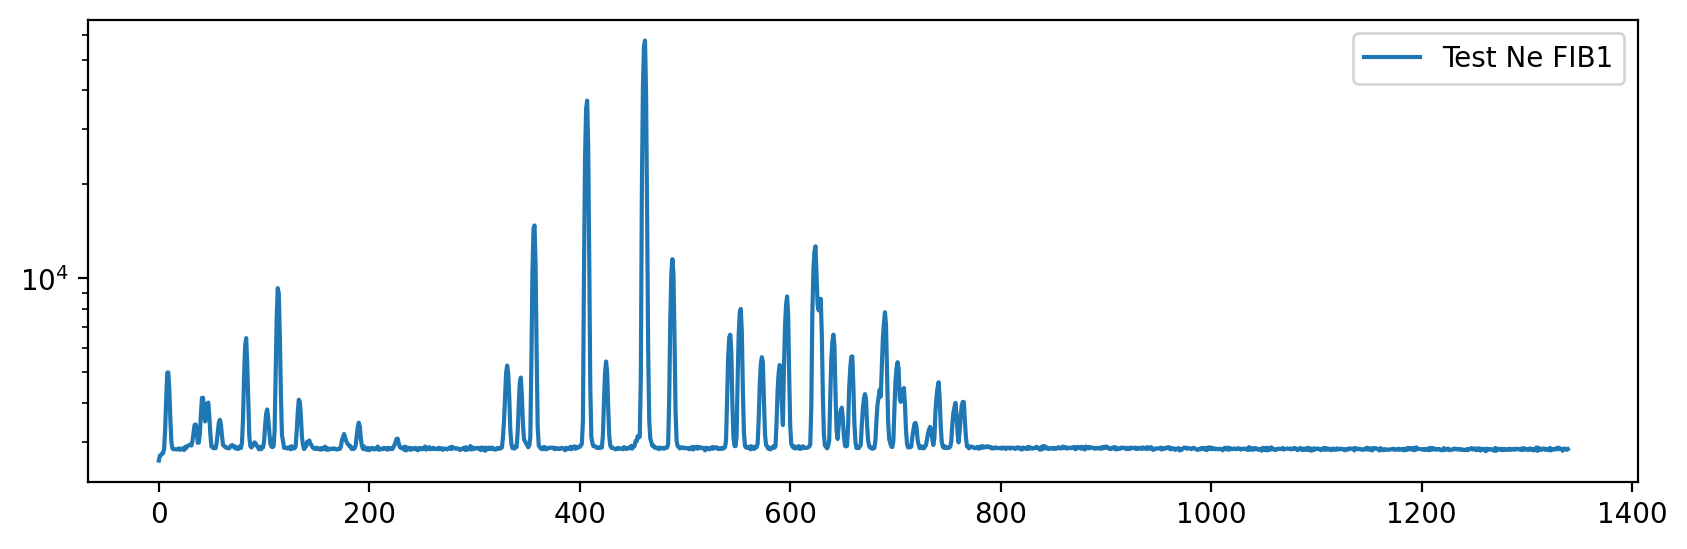

In [254]:
new_fpath = TESTDIR / "Ne_150_620_0_converted.fits"
fpath_im = new_fpath.parent / (new_fpath.stem + "_im.fits")
fpath_ex = new_fpath.parent / (new_fpath.stem + "_ex.fits")

hdul = fits.open(fpath_ex)
hdul.info()
tlm_hdul = fits.open(fpath_tlm)
wavela = tlm_hdul[1].data[0]


fig = plt.figure(figsize=(10, 3))
ax = fig.add_subplot(111)
# ax.imshow(hdul[0].data, cmap='gray', origin='lower')
# ax.set_xlim(800, 900)
ax.plot(hdul[0].data[0], label="Test Ne FIB1")
ax.set_yscale("log")
ax.legend()
plt.show()

near_f1 = hdul[0].data[0][::-1]

In [255]:
im = ImageFile(fpath_im.as_posix(), mode='READ')
im.open()
print(im.read_header_keyword("LAMBDAC"))
print(im.read_header_keyword("DISPERS"))
print(im.read_header_keyword("GRATLPMM"))
print(im.read_header_keyword("GRATID"))
print(im.read_header_keyword("SPECTID"))
print(im.read_header_keyword("OBSTYPE"))


INFO:kspecdr.io.image:Opened file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/Ne_150_620_0_converted_im.fits (mode: READ)
('6200.0', 'Central wavelength in Angstrom')
('-3.68', 'Central dispersion (Angstrom/pixel)')
('150', 'Grating Lines per mm')
('150', 'Grating ID')
('UNKNOWN', 'Spectrograph ID')
('OBJECT', 'Observation type')


In [256]:
fpath = TESTDIR / r"intellical_near_150_620_f1 2025-12-24.fits"
hdul = fits.open(fpath)
hdr = hdul[0].header
# cleaned_hdr = sanitize_header_drop_unparsable(hdr)
new_hdr = convert_isoplane_header(hdr, ndfclass="MFARC")

# add fiber table
add_fiber_table(hdul, n_fibers=16)

# just use the first frame for now
hdul[0].data = hdul[0].data[0]
# make new fits file with new header and fiber table
new_hdr["NAXIS"] = 2
new_hdr.remove("NAXIS3")
hdul[0].header = new_hdr

new_fpath = TESTDIR / "intellical_near_150_620_f1_converted.fits"
hdul.writeto(new_fpath, overwrite=True)

make_im(new_fpath.as_posix(),
        cosmic_ray_method='NONE',
        verbose=False)

fpath_im = new_fpath.parent / (new_fpath.stem + "_im.fits")
fpath_ex = new_fpath.parent / (new_fpath.stem + "_ex.fits")
args = {"IMAGE_FILENAME": fpath_im.as_posix(),
        "EXTRAC_FILENAME": fpath_ex.as_posix(),
        "TLMAP_FILENAME": fpath_tlm.as_posix(),}

make_ex(args)

INFO:kspecdr.preproc.make_im:Creating IM file from raw data with TDFIO_CREATEBYCOPY functionality...
INFO:kspecdr.preproc.make_im:Creating IM file from raw file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/intellical_near_150_620_f1_converted.fits -> /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/intellical_near_150_620_f1_converted_im.fits
INFO:kspecdr.io.image:Opened file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/intellical_near_150_620_f1_converted.fits (mode: READ)
INFO:kspecdr.preproc.make_im:Instrument: ISOPLANE, SPECTID: UNKNOWN, CLASS: , BITPIX: 16
INFO:kspecdr.io.image:Closed file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/intellical_near_150_620_f1_converted.fits
INFO:kspecdr.io.image:Opened file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/intellical_near_150_620_f1_converted.fits (mode: READ)
INFO:kspecdr.preproc.make_im:Creating variance HDU for raw file
INFO:kspecdr.preproc.ma

INFO:kspecdr.io.image:Closed file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/intellical_near_150_620_f1_converted_im.fits
INFO:kspecdr.io.image:Closed file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/intellical_near_150_620_f1_converted.fits
INFO:kspecdr.preproc.make_im:Successfully created IM file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/intellical_near_150_620_f1_converted_im.fits
INFO:kspecdr.io.image:Opened file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/intellical_near_150_620_f1_converted_im.fits (mode: UPDATE)
INFO:kspecdr.preproc.make_im:No bias subtraction performed
INFO:kspecdr.preproc.make_im:Variance HDU created and initialized
INFO:kspecdr.io.image:Closed file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/intellical_near_150_620_f1_converted_im.fits
INFO:kspecdr.extract.make_ex:Extracting /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/intellical_near_150_6

Filename: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/intellical_near_150_620_f1_converted_ex.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     205   (1340, 16)   float32   
  1  VARIANCE      1 ImageHDU         8   (1340, 16)   float32   
  2  WAVELA        1 ImageHDU         8   (1340, 16)   float32   


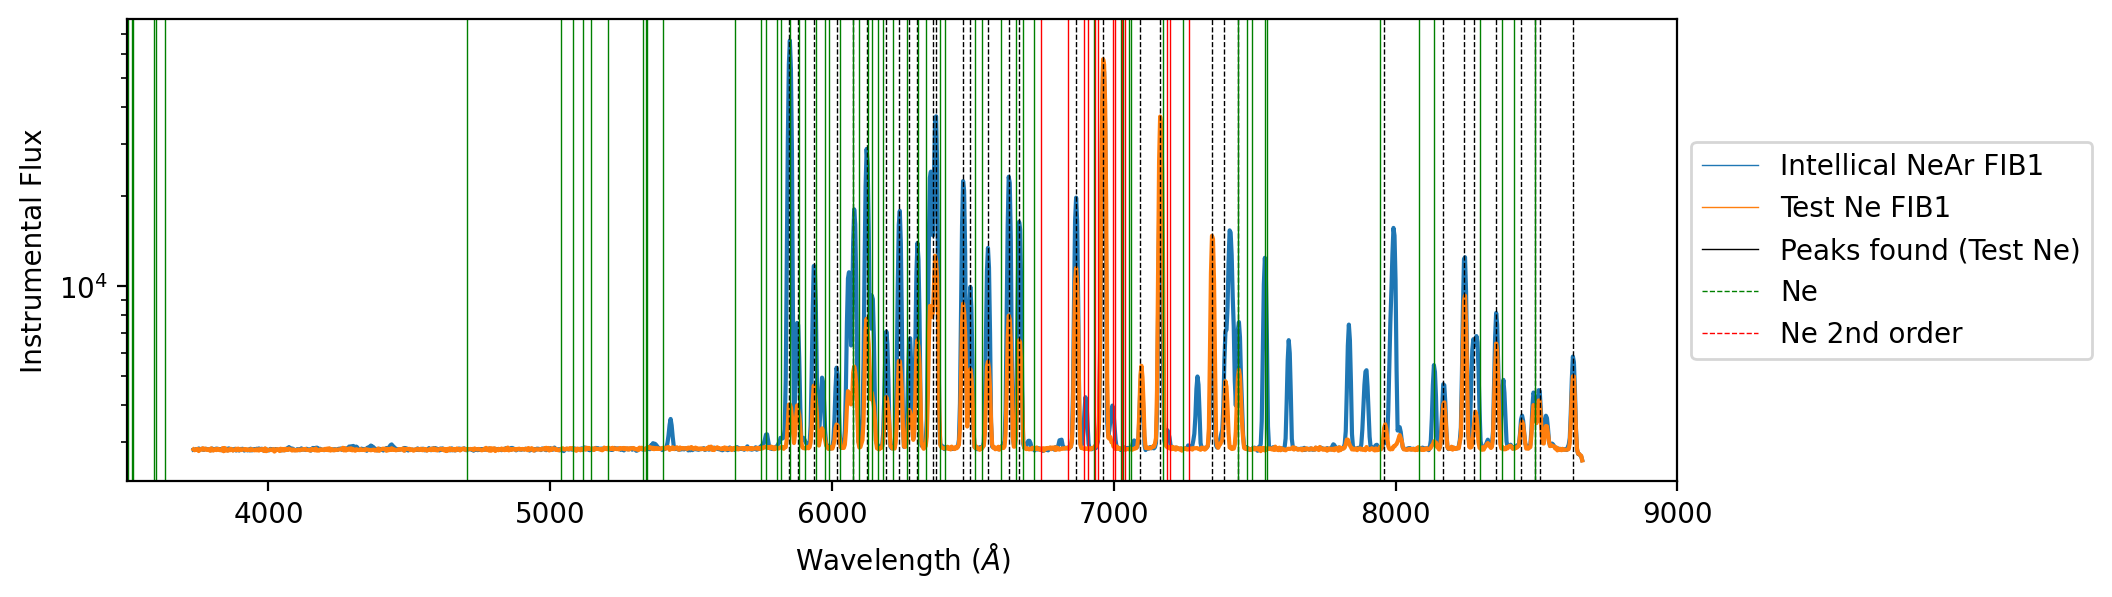

In [257]:
new_fpath = TESTDIR / "intellical_near_150_620_f1_converted.fits"
fpath_im = new_fpath.parent / (new_fpath.stem + "_im.fits")
fpath_ex = new_fpath.parent / (new_fpath.stem + "_ex.fits")

hdul = fits.open(fpath_ex)
hdul.info()
tlm_hdul = fits.open(fpath_tlm)
wavela = tlm_hdul[1].data[0]

intellical_near_f1 = hdul[0].data[0][::-1]

peaks = find_peaks_cwt(near_f1, widths=3, min_snr=2)
peaks, _ = find_peaks(near_f1, height=1000, width=(0, 15), prominence=500)
peaks = refine_peaks(near_f1, peaks, window_width=5)

fig = plt.figure(figsize=(10, 3))
ax = fig.add_subplot(111)
ax.plot(pix2lam, intellical_near_f1, label="Intellical NeAr FIB1")
ax.plot(pix2lam, near_f1, label="Test Ne FIB1")

for p in peaks:
    ax.axvline(pix2lam[int(p)], color="k", lw=0.5, ls="--")

for line in newport_ne["Wavelength (nm)"]:
    ax.axvline(line*10, color="g", lw=0.5)
    
for line in newport_ne["Wavelength (nm)"]:
    ax.axvline(line*20, color="r", lw=0.5)
# for line in newport_ar["Wavelength (nm)"]:
#     ax.axvline(line*10, color="r", lw=0.5, ls="--")

legend_lines = [
    Line2D([0], [0], color="tab:blue", lw=0.5, label="Intellical NeAr FIB1"),
    Line2D([0], [0], color="tab:orange", lw=0.5, label="Test Ne FIB1"),
    Line2D([0], [0], color="k", lw=0.5, label="Peaks found (Test Ne)"),
    Line2D([0], [0], color="g", lw=0.5, ls="--", label="Ne"),
    Line2D([0], [0], color="r", lw=0.5, ls="--", label="Ne 2nd order")]
ax.legend(handles=legend_lines, loc='center left', bbox_to_anchor=(1, 0.5))

ax.set_xlim(3500, 9000)

ax.set_yscale("log")
ax.set_xlabel(r"Wavelength ($\AA$)")
ax.set_ylabel("Instrumental Flux")
# ax.legend()
plt.show()

In [258]:
import numpy as np
import plotly.graph_objects as go

def to_native_float(a):
    a = np.asarray(a)

    if a.dtype.byteorder not in ("=", "|"):
        a = a.byteswap().view(a.dtype.newbyteorder("="))

    return np.ascontiguousarray(a, dtype=np.float64)

# Convert arrays for Plotly (native endian)
x = to_native_float(pix2lam)
y1 = to_native_float(intellical_near_f1)
y2 = to_native_float(near_f1)

fig = go.Figure()
# fig.add_trace(go.Scatter(x=x, y=y1, mode="lines", name="Intellical Hg FIB1"))
fig.add_trace(go.Scatter(x=x, y=y2, mode="lines", name="Test HgAr FIB1"))

# for p in peaks:
#     fig.add_vline(x=float(x[int(p)]), line_width=0.5, line_color="black")

# for line in newport_hgar["Wavelength (nm)"]:
#     fig.add_vline(x=float(line) * 10.0, line_width=0.5, line_dash="dash", line_color="red", name="Hg")

ymin = np.nanmin(y1[y1 > 0])
ymax = np.nanmax(y1)

for p in peaks:
    xp = float(x[int(p)])

    fig.add_trace(
        go.Scatter(
            x=[xp, xp],
            y=[ymin, ymax],
            mode="lines",
            line=dict(color="black", width=0.5, dash="dash"),
            hovertemplate=(
                "Peak<br>"
                f"pixel = {p:.2f}<br>"
                "λ = %{x:.2f}<br>"
                "<extra></extra>"
            ),
            showlegend=False
        )
    )

for line in newport_ne["Wavelength (nm)"]:
    lam = float(line) * 10.0
    fig.add_trace(
        go.Scatter(
            x=[lam, lam],
            y=[ymin, ymax],
            mode="lines",
            line=dict(color="red", width=0.5),
            hovertemplate=(
                "Ne line<br>"
                "λ = %{x:.2f}<br>"
                "<extra></extra>"
            ),
            showlegend=False
        )
    )
for line in newport_ne["Wavelength (nm)"]:
    lam = float(line) * 10.0 * 2
    fig.add_trace(
        go.Scatter(
            x=[lam, lam],
            y=[ymin, ymax],
            mode="lines",
            line=dict(color="yellow", width=0.5),
            hovertemplate=(
                "Ne 2rd line<br>"
                "λ = %{x:.2f}<br>"
                "<extra></extra>"
            ),
            showlegend=False
        )
    )

fig.update_layout(
    width=1000,
    height=300,
    yaxis_type="log",
    xaxis_range=[3500, 9000],
    margin=dict(l=60, r=20, t=40, b=40),
    legend=dict(orientation="h", y=1.02, x=1, xanchor="right", yanchor="bottom"),
)

fig.show()

In [259]:
user_pks_ne = [574.99, 583.19, 598.43, 620.13, 636.23, 649.42, 668.10, 680.73, 690.52, 698.49, 713.96, 716.34, 742.34, 749.72, 766.00, 786.37, 796.28, 851.03, 877.53, 913.87, 932.42, 982.40, 994.99, 1007.96, 1148.79, 1205.57, 1225.64, 1235.91, 1256.11, 1293.78]
user_atl_ne = [5852.5, 5881.9, 5944.8, 6030.0, 6096.2, 6143.1, 6217.3, 6266.5, 6304.8, 6334.4, 6383.0, 6402.3, 6506.5, 6532.9, 6599.0, 6678.3, 6717.0, 6929.5, 7024.1, 7173.9, 7245.2, 7438.9, 7488.9, 7535.80, 8082.50, 8300.30, 8377.60, 8418.40, 8495.40, 8634.65]

In [260]:
fpath = TESTDIR / r"Kr_150_620_0.fits"
hdul = fits.open(fpath)
hdr = hdul[0].header
# cleaned_hdr = sanitize_header_drop_unparsable(hdr)
new_hdr = convert_isoplane_header(hdr, ndfclass="MFARC")

# add fiber table
add_fiber_table(hdul, n_fibers=16)

# just use the first frame for now
hdul[0].data = hdul[0].data[0]
# make new fits file with new header and fiber table
new_hdr["NAXIS"] = 2
new_hdr.remove("NAXIS3")
hdul[0].header = new_hdr

new_fpath = TESTDIR / "Kr_150_620_0_converted.fits"
hdul.writeto(new_fpath, overwrite=True)

make_im(new_fpath.as_posix(),
        cosmic_ray_method='NONE',
        verbose=False)

fpath_im = new_fpath.parent / (new_fpath.stem + "_im.fits")
fpath_ex = new_fpath.parent / (new_fpath.stem + "_ex.fits")
args = {"IMAGE_FILENAME": fpath_im.as_posix(),
        "EXTRAC_FILENAME": fpath_ex.as_posix(),
        "TLMAP_FILENAME": fpath_tlm.as_posix(),}

make_ex(args)

INFO:kspecdr.preproc.make_im:Creating IM file from raw data with TDFIO_CREATEBYCOPY functionality...
INFO:kspecdr.preproc.make_im:Creating IM file from raw file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/Kr_150_620_0_converted.fits -> /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/Kr_150_620_0_converted_im.fits
INFO:kspecdr.io.image:Opened file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/Kr_150_620_0_converted.fits (mode: READ)
INFO:kspecdr.preproc.make_im:Instrument: ISOPLANE, SPECTID: UNKNOWN, CLASS: , BITPIX: 16
INFO:kspecdr.io.image:Closed file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/Kr_150_620_0_converted.fits
INFO:kspecdr.io.image:Opened file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/Kr_150_620_0_converted.fits (mode: READ)
INFO:kspecdr.preproc.make_im:Creating variance HDU for raw file
INFO:kspecdr.preproc.make_im:Copying fiber table from source file
INFO:kspecdr.io.image:Opene

Filename: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/Kr_150_620_0_converted_ex.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     195   (1340, 16)   float32   
  1  VARIANCE      1 ImageHDU         8   (1340, 16)   float32   
  2  WAVELA        1 ImageHDU         8   (1340, 16)   float32   


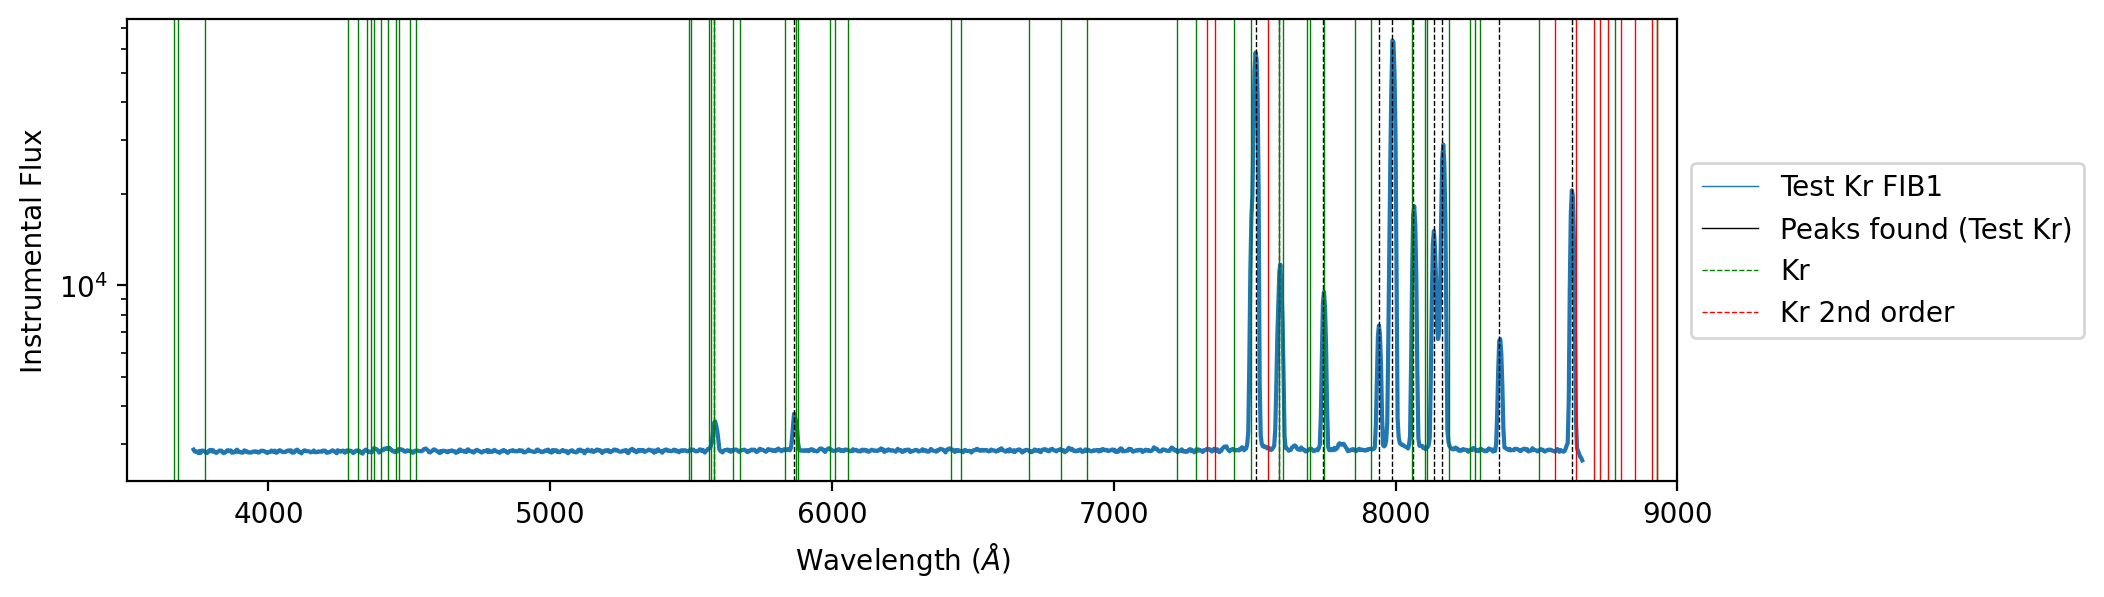

In [261]:
new_fpath = TESTDIR / "Kr_150_620_0_converted.fits"
fpath_im = new_fpath.parent / (new_fpath.stem + "_im.fits")
fpath_ex = new_fpath.parent / (new_fpath.stem + "_ex.fits")

hdul = fits.open(fpath_ex)
hdul.info()
tlm_hdul = fits.open(fpath_tlm)
wavela = tlm_hdul[1].data[0]

kr_f1 = hdul[0].data[0][::-1]

# peaks = find_peaks_cwt(kr_f1, widths=3, min_snr=2)
peaks, _ = find_peaks(kr_f1, height=1000, width=(0, 15), prominence=500)
peaks = refine_peaks(kr_f1, peaks, window_width=5)

fig = plt.figure(figsize=(10, 3))
ax = fig.add_subplot(111)
# ax.imshow(hdul[0].data, cmap='gray', origin='lower')
# ax.set_xlim(800, 900)
pixel = np.arange(len(kr_f1))
pix2lam = (pixel - len(pixel)/2)*3.68 + 6200
ax.plot(pix2lam, kr_f1, label="Test Kr FIB1")

newport_kr = newport_oriel[newport_oriel["Model No."] == 6031]

for p in peaks:
    ax.axvline(pix2lam[int(p)], color="k", lw=0.5, ls="--")

for line in newport_kr["Wavelength (nm)"]:
    ax.axvline(line*10, color="g", lw=0.5)
    
for line in newport_kr["Wavelength (nm)"]:
    ax.axvline(line*20, color="r", lw=0.5)
# for line in newport_ar["Wavelength (nm)"]:
#     ax.axvline(line*10, color="r", lw=0.5, ls="--")

legend_lines = [
    Line2D([0], [0], color="tab:blue", lw=0.5, label="Test Kr FIB1"),
    Line2D([0], [0], color="k", lw=0.5, label="Peaks found (Test Kr)"),
    Line2D([0], [0], color="g", lw=0.5, ls="--", label="Kr"),
    Line2D([0], [0], color="r", lw=0.5, ls="--", label="Kr 2nd order")]
ax.legend(handles=legend_lines, loc='center left', bbox_to_anchor=(1, 0.5))

ax.set_xlim(3500, 9000)

ax.set_yscale("log")
ax.set_xlabel(r"Wavelength ($\AA$)")
ax.set_ylabel("Instrumental Flux")
# ax.legend()
plt.show()

In [262]:
import numpy as np
import plotly.graph_objects as go

def to_native_float(a):
    a = np.asarray(a)

    if a.dtype.byteorder not in ("=", "|"):
        a = a.byteswap().view(a.dtype.newbyteorder("="))

    return np.ascontiguousarray(a, dtype=np.float64)

# Convert arrays for Plotly (native endian)
x = to_native_float(pix2lam)
y1 = to_native_float(intellical_near_f1)
y2 = to_native_float(kr_f1)

fig = go.Figure()
# fig.add_trace(go.Scatter(x=x, y=y1, mode="lines", name="Intellical Hg FIB1"))
fig.add_trace(go.Scatter(x=x, y=y2, mode="lines", name="Test HgAr FIB1"))

# for p in peaks:
#     fig.add_vline(x=float(x[int(p)]), line_width=0.5, line_color="black")

# for line in newport_hgar["Wavelength (nm)"]:
#     fig.add_vline(x=float(line) * 10.0, line_width=0.5, line_dash="dash", line_color="red", name="Hg")

ymin = np.nanmin(y1[y1 > 0])
ymax = np.nanmax(y1)

for p in peaks:
    xp = float(x[int(p)])

    fig.add_trace(
        go.Scatter(
            x=[xp, xp],
            y=[ymin, ymax],
            mode="lines",
            line=dict(color="black", width=0.5, dash="dash"),
            hovertemplate=(
                "Peak<br>"
                f"pixel = {p:.2f}<br>"
                "λ = %{x:.2f}<br>"
                "<extra></extra>"
            ),
            showlegend=False
        )
    )

for line in newport_kr["Wavelength (nm)"]:
    lam = float(line) * 10.0
    fig.add_trace(
        go.Scatter(
            x=[lam, lam],
            y=[ymin, ymax],
            mode="lines",
            line=dict(color="red", width=0.5),
            hovertemplate=(
                "Kr line<br>"
                "λ = %{x:.2f}<br>"
                "<extra></extra>"
            ),
            showlegend=False
        )
    )
for line in newport_kr["Wavelength (nm)"]:
    lam = float(line) * 10.0 * 2
    fig.add_trace(
        go.Scatter(
            x=[lam, lam],
            y=[ymin, ymax],
            mode="lines",
            line=dict(color="yellow", width=0.5),
            hovertemplate=(
                "Kr 2rd line<br>"
                "λ = %{x:.2f}<br>"
                "<extra></extra>"
            ),
            showlegend=False
        )
    )

fig.update_layout(
    width=1000,
    height=300,
    yaxis_type="log",
    xaxis_range=[3500, 9000],
    margin=dict(l=60, r=20, t=40, b=40),
    legend=dict(orientation="h", y=1.02, x=1, xanchor="right", yanchor="bottom"),
)

fig.show()

In [263]:
user_pks_kr = [502.74, 579.51, 1024.09, 1047.66, 1089.97, 1143.00, 1156.57, 1176.94, 1196.30, 1204.94, 1259.73, 1329.28,]
user_atl_kr = [5570.3, 5870.9, 7601.50, 7685.20, 7854.80, 8059.50, 8104.40, 8190.10, 8263.20, 8298.10, 8508.90, 8776.70,]

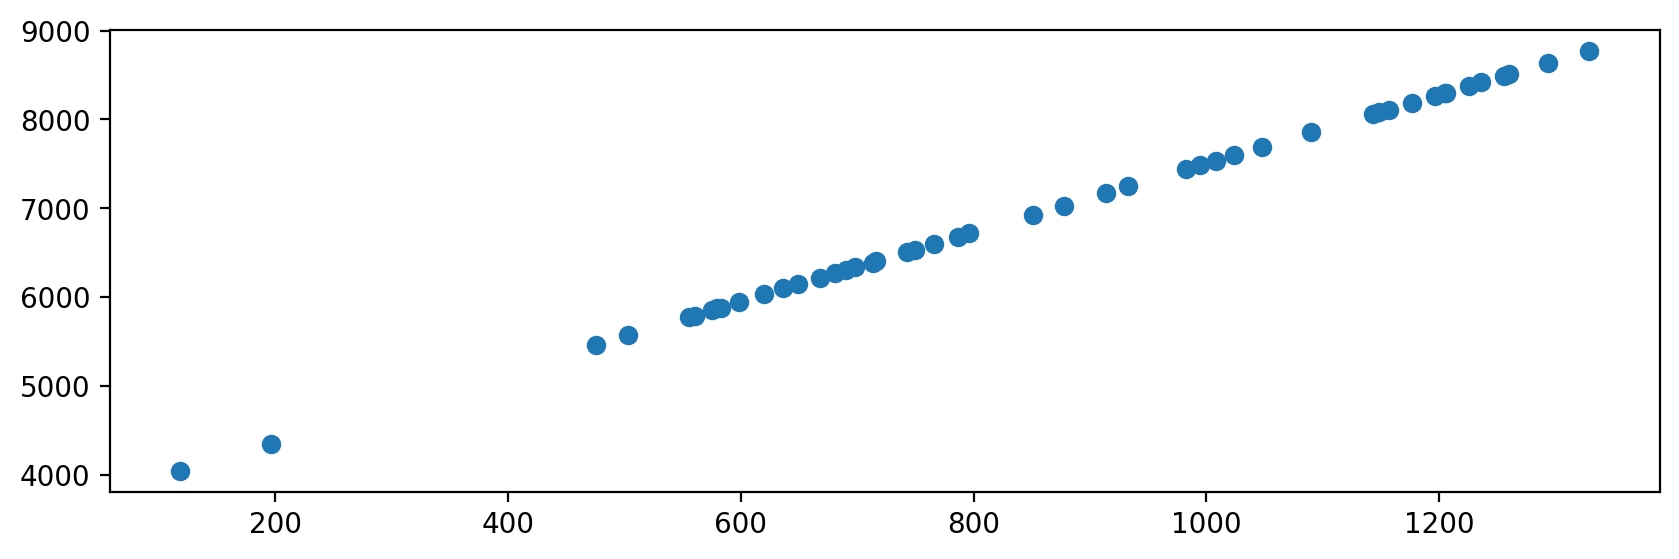

In [264]:
user_pks = np.array(user_pks_kr + user_pks_ne + user_pks_hg)
user_atl = np.array(user_atl_kr + user_atl_ne + user_atl_hg)

fig = plt.figure(figsize=(10, 3))
ax = fig.add_subplot(111)
ax.plot(user_pks, user_atl, label="User", marker="o", ls="")


In [265]:
from rascal.calibrator import Calibrator

c = Calibrator(user_pks)

c.set_hough_properties(
    num_slopes=5000,
    range_tolerance=500.0,
    xbins=200,
    ybins=200,
    min_wavelength=3500.0,
    max_wavelength=9500.0,
    linearity_tolerance=50.0,
)
c.set_ransac_properties(sample_size=5, top_n_candidate=5)

from rascal.atlas import Atlas

arclines_hg = newport_hgar["Wavelength (nm)"].data * 10
arclines_ar = newport_ar["Wavelength (nm)"].data * 10

arclines = user_atl
elements = ["Kr"] * len(user_atl_kr) + ["Ne"] * len(user_atl_ne) + ["Hg"] * len(user_atl_hg)

atlas = Atlas(
    min_atlas_wavelength=3000.0,
    max_atlas_wavelength=9500.0,
    min_intensity=0.0,
)
atlas.add_user_atlas(
    elements=elements,
    wavelengths=arclines,
)

c.set_atlas(atlas)

c.do_hough_transform()

fit_result = c.fit(max_tries=500, fit_deg=4)
(
    fit_coeff,
    matched_peaks,
    matched_atlas,
    rms,
    residual,
    peak_utilisation,
    atlas_utilisation,
) = fit_result

[Thu, 08 Jan 2026 00:41:37] WARNING [calibrator.py:846] object of type 'NoneType' has no len()
[Thu, 08 Jan 2026 00:41:37] WARNING [calibrator.py:847] Neither num_pix nor spectrum is given, it uses 1.1 times max(peaks) as the maximum pixel value.


  0%|          | 0/500 [00:00<?, ?it/s]

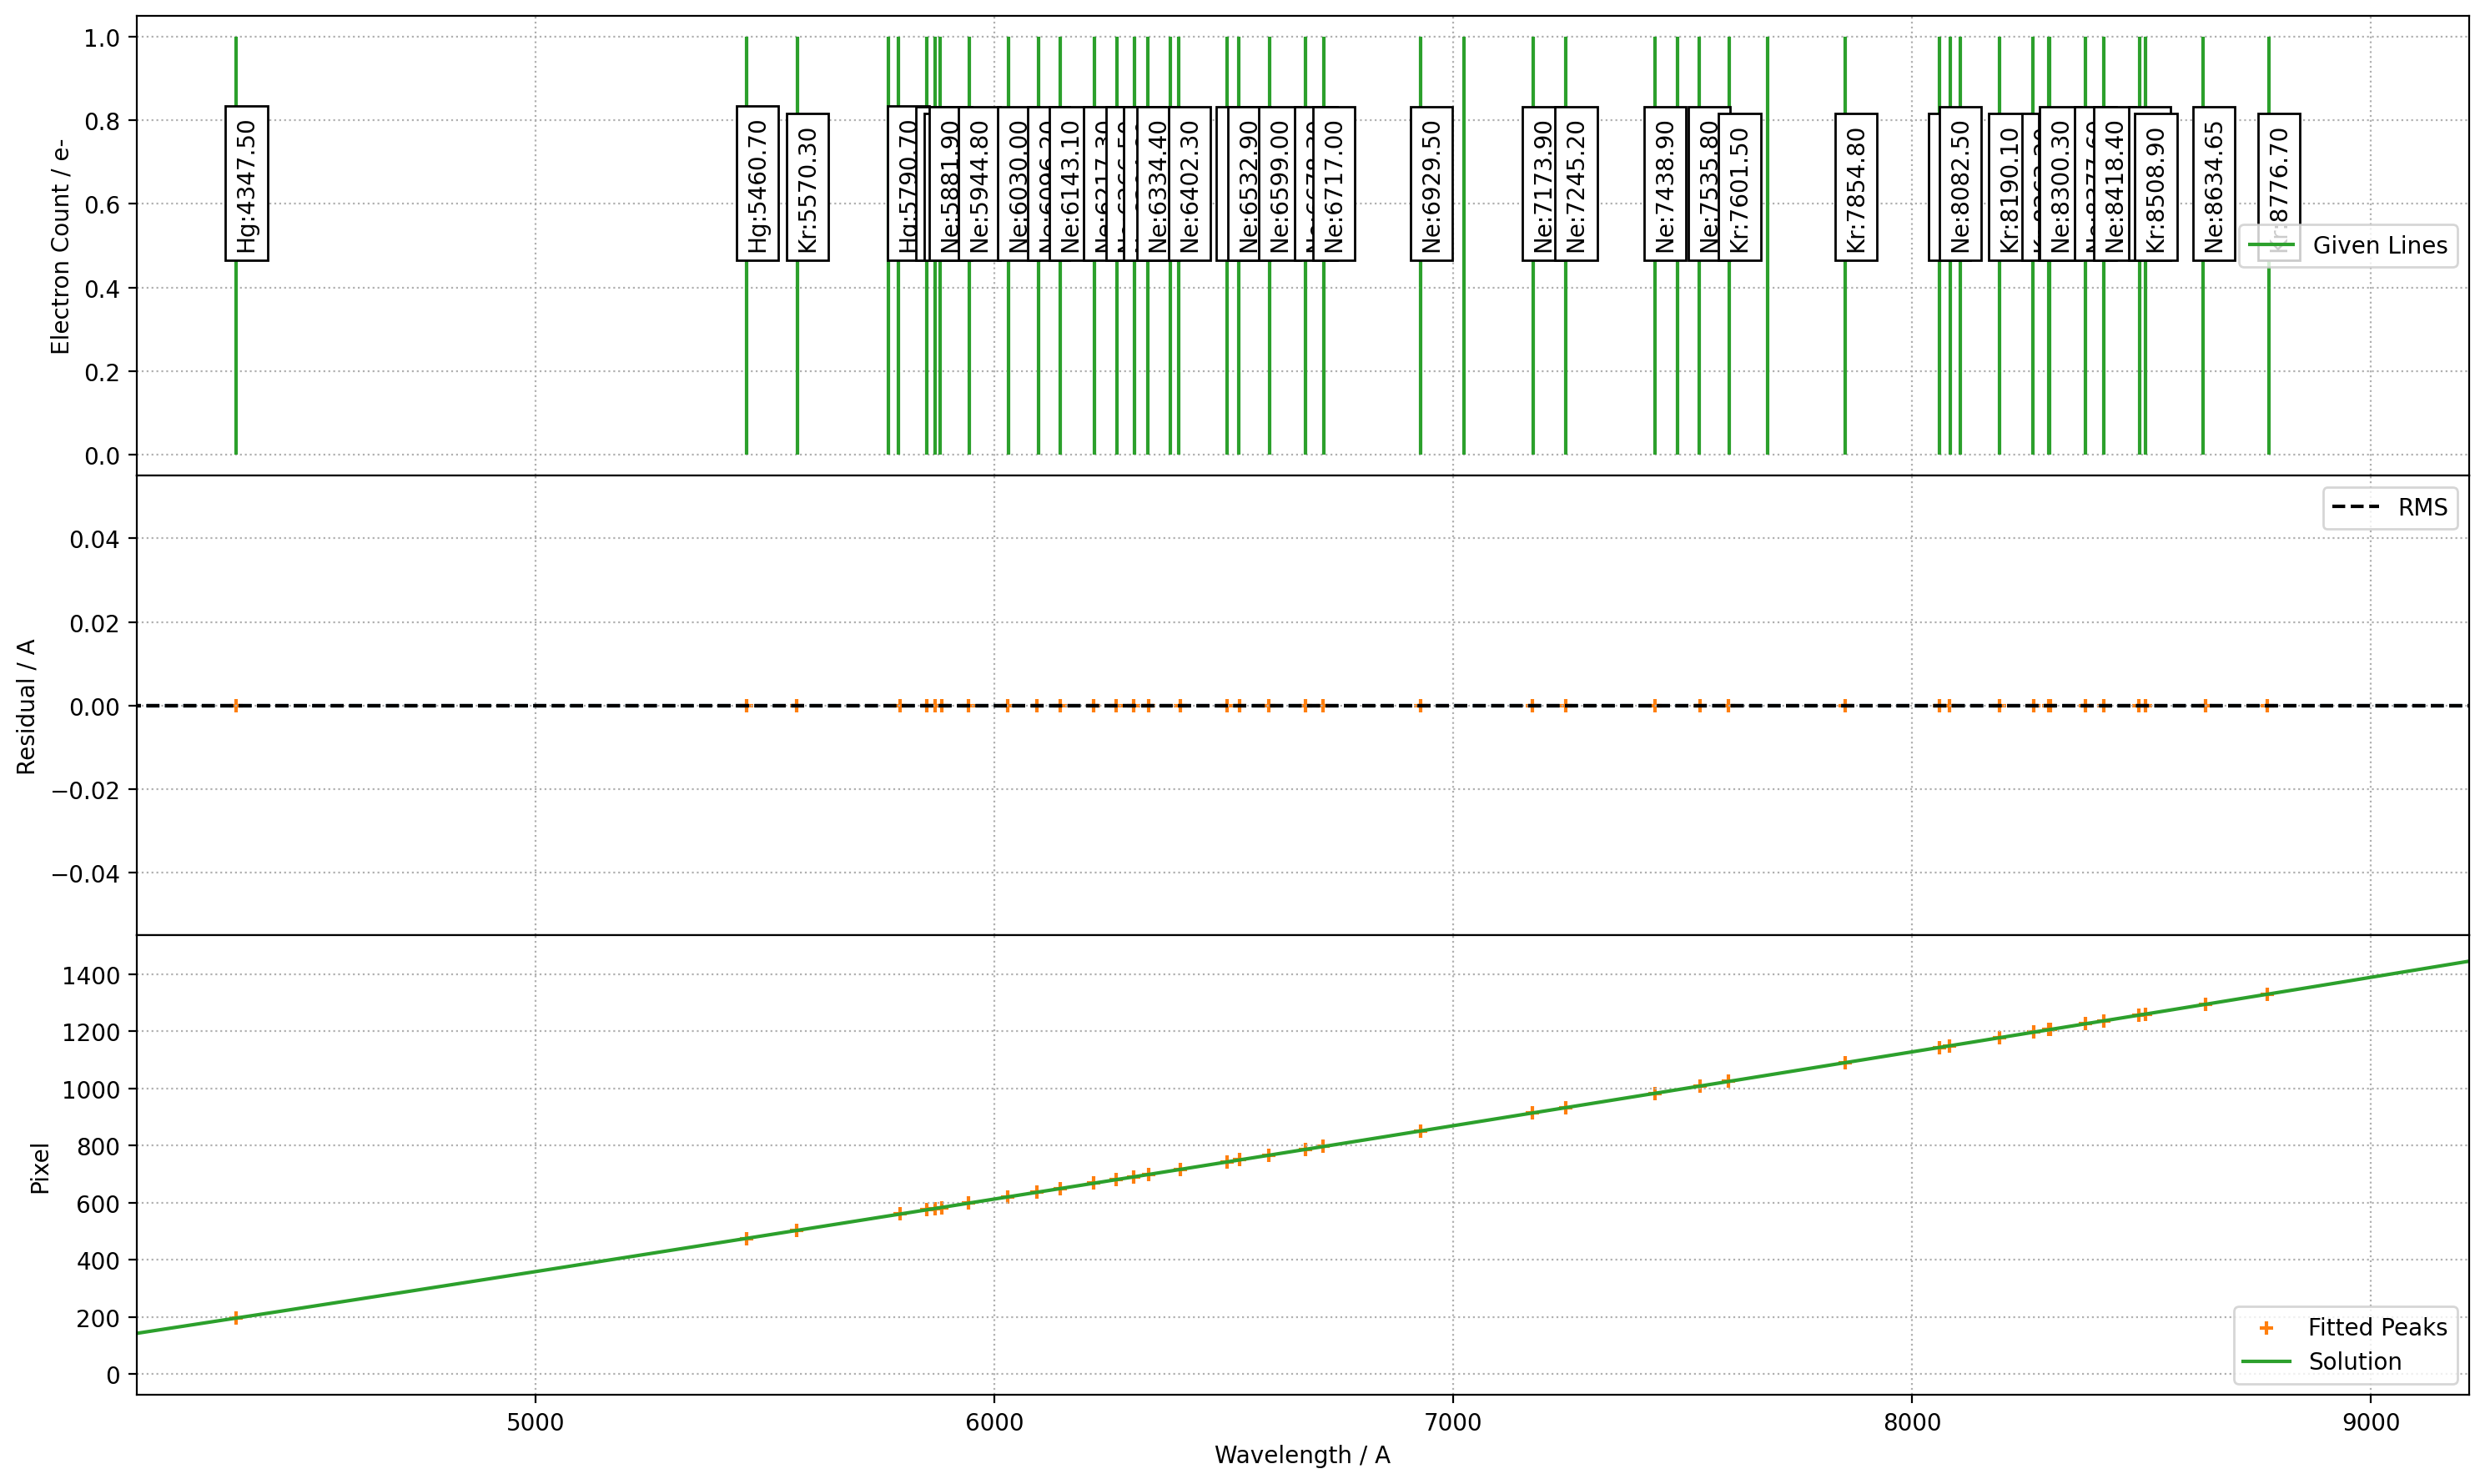

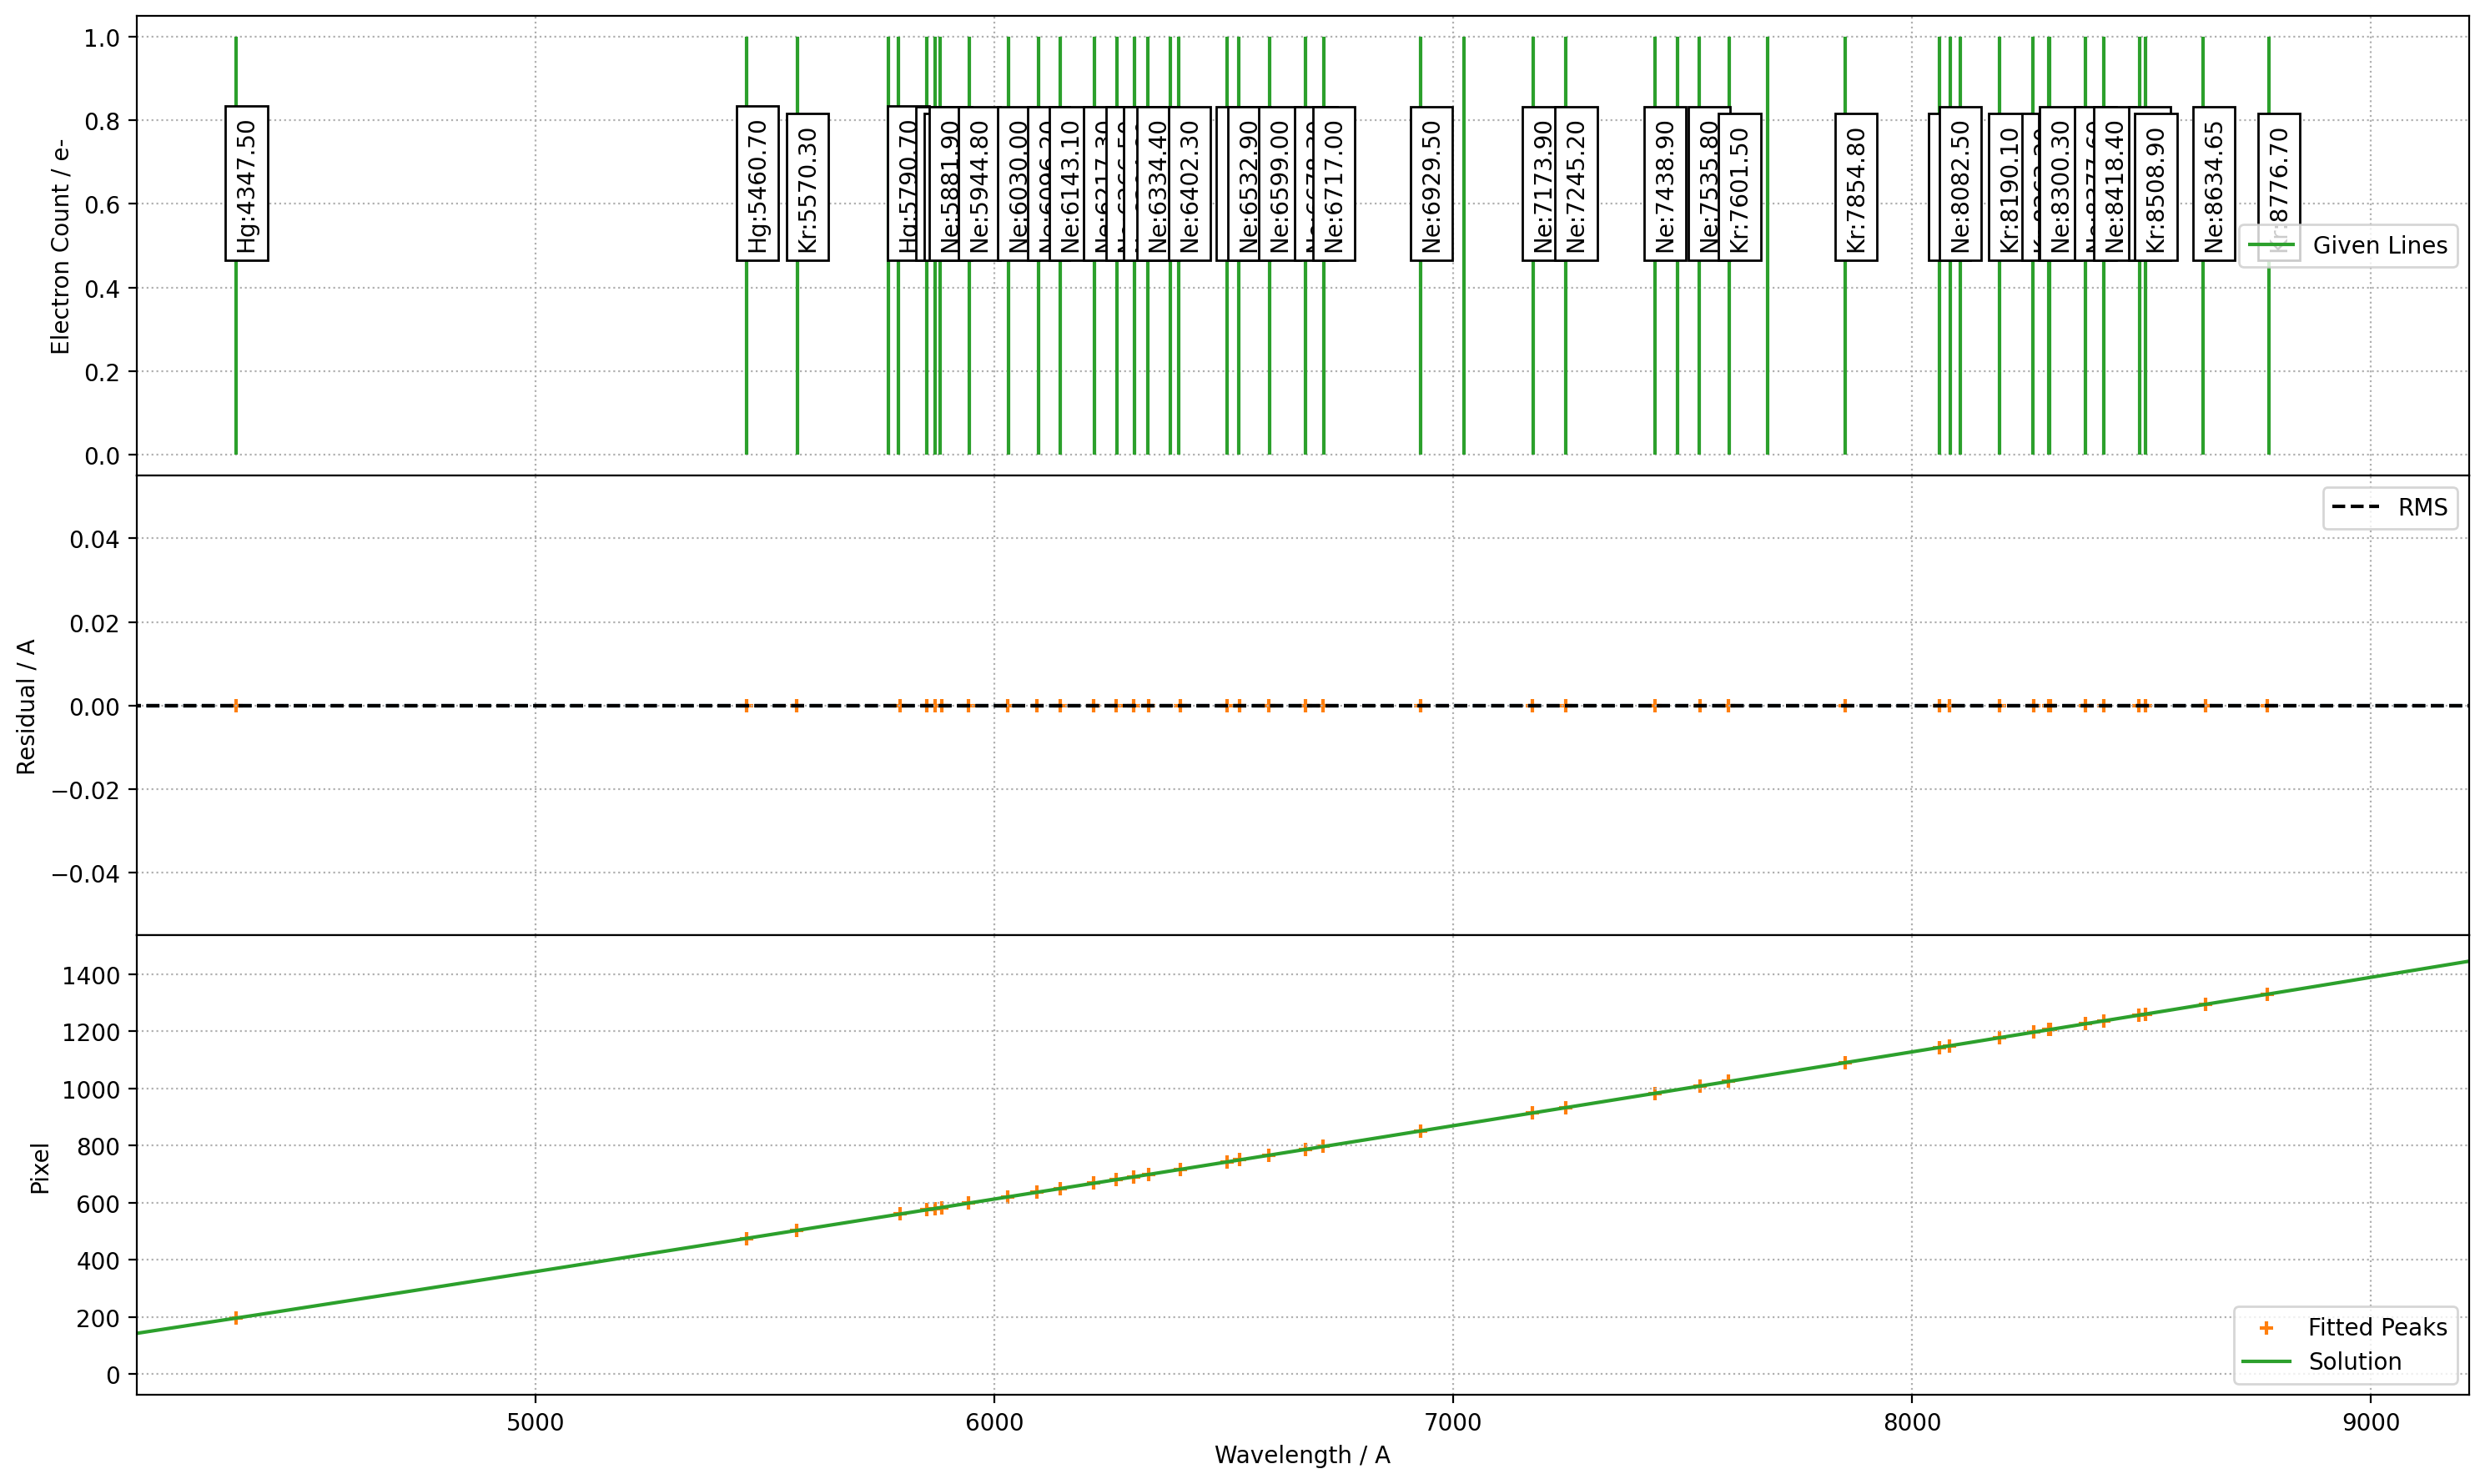

In [266]:
c.plot_fit(fit_coeff)

In [267]:
fit_coeff

array([ 3.54049815e+03,  4.18080779e+00, -4.07600260e-04,  2.66990499e-07,
       -7.37470087e-11])

In [268]:
rms

np.float64(1.544556620686679)

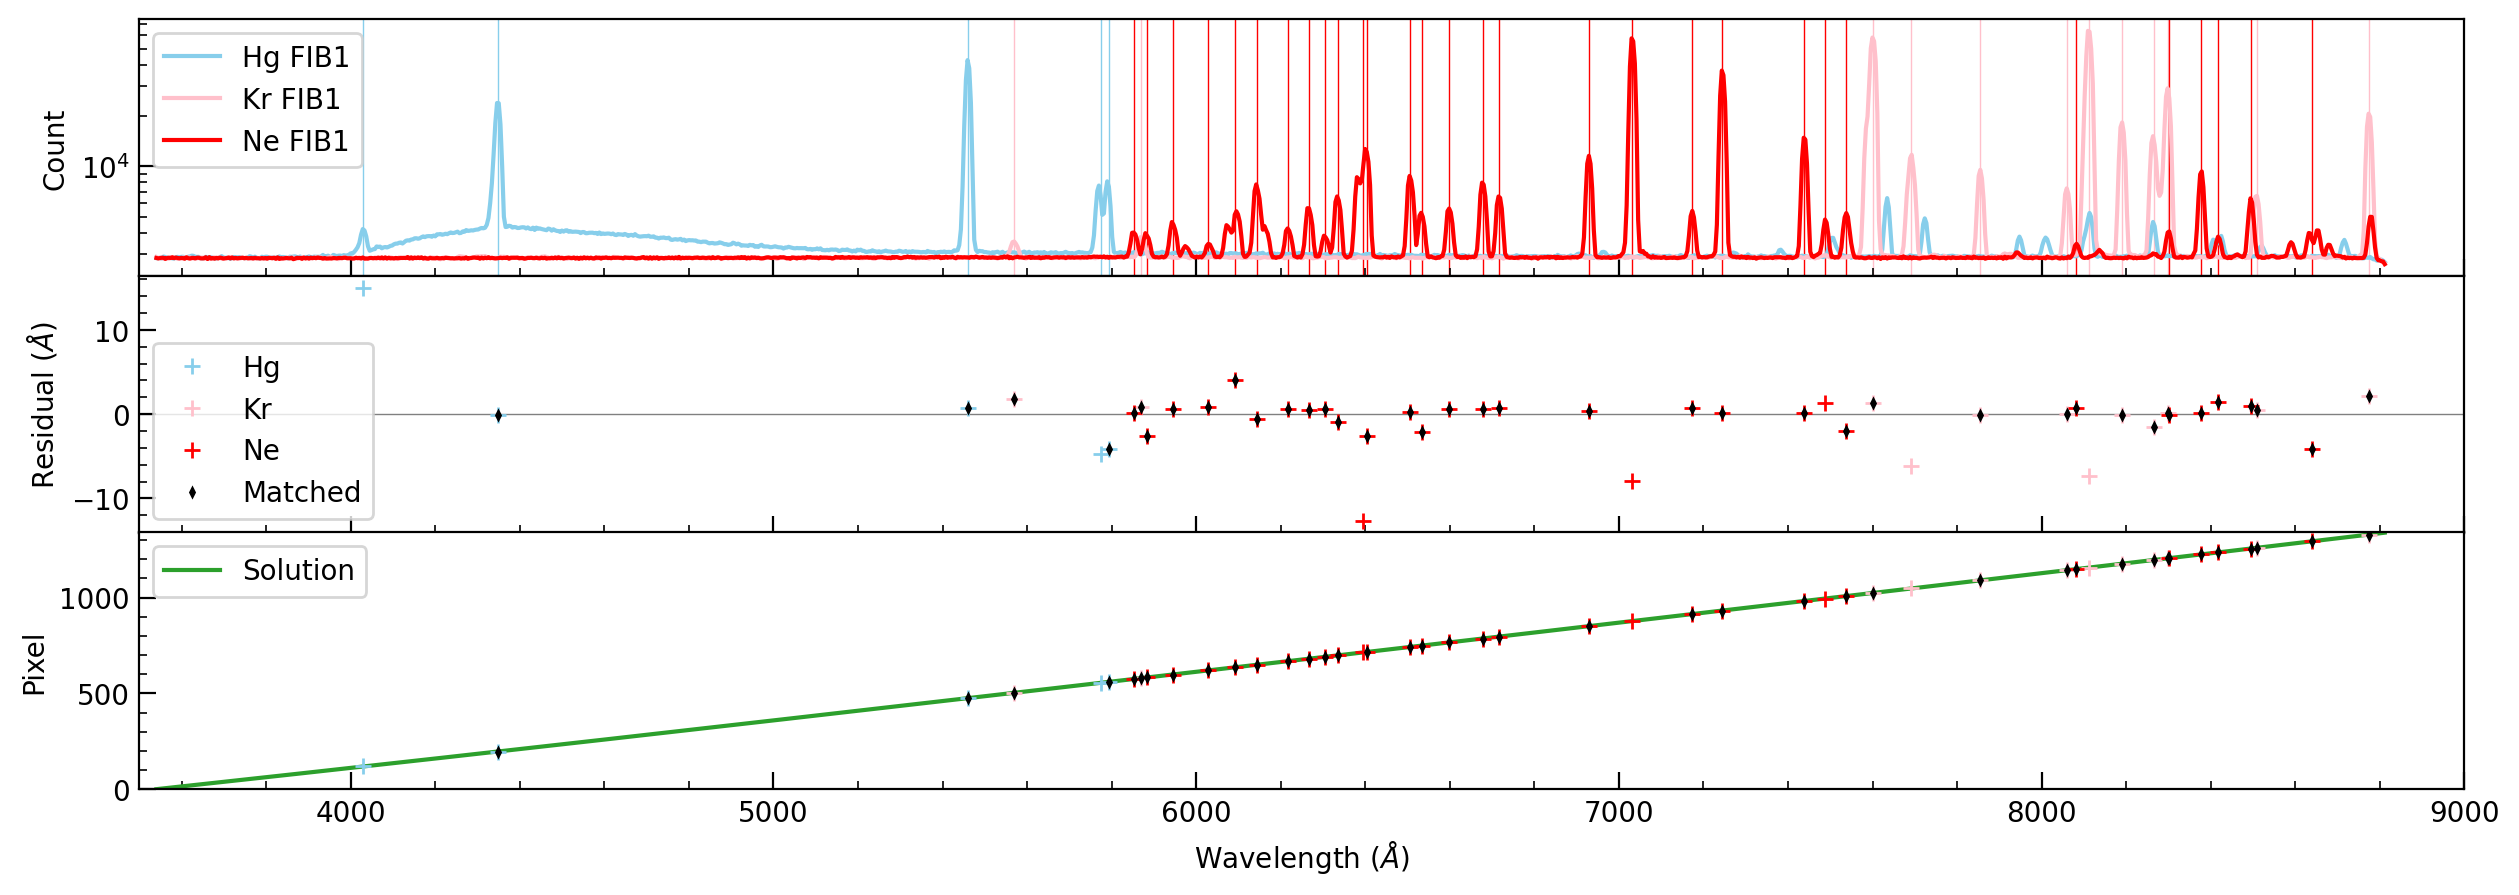

In [269]:
fig, axes = plt.subplots(3, 1, figsize=(15, 5), sharex=True)
ax = axes[0]
solx = c.polyval(np.arange(len(hg_f1)), fit_coeff)
ax.plot(solx, hg_f1, label="Hg FIB1", c="skyblue")
ax.plot(solx, kr_f1, label="Kr FIB1", c="pink")
ax.plot(solx, near_f1, label="Ne FIB1", c="red")
for x in user_pks_hg:
    lam = c.polyval(x, fit_coeff)
    ax.axvline(lam, color="skyblue", lw=0.5, zorder=0)
for x in user_pks_kr:
    lam = c.polyval(x, fit_coeff)
    ax.axvline(lam, color="pink", lw=0.5, zorder=0)
for x in user_pks_ne:
    lam = c.polyval(x, fit_coeff)
    ax.axvline(lam, color="red", lw=0.5, zorder=0)
ax.legend()
ax.set_yscale("log")
ax.set_xlim(3500, 9000)
ax.set_ylabel("Count")

ax = axes[1]
lam_pks_hg = c.polyval(user_pks_hg, fit_coeff)
lam_pks_kr = c.polyval(user_pks_kr, fit_coeff)
lam_pks_ne = c.polyval(user_pks_ne, fit_coeff)
residual_hg = np.array(user_atl_hg) - lam_pks_hg
residual_kr = np.array(user_atl_kr) - lam_pks_kr
residual_ne = np.array(user_atl_ne) - lam_pks_ne
lam_pks_matched = c.polyval(c.matched_peaks, fit_coeff)
residual_matched = c.matched_atlas - lam_pks_matched
ax.plot(lam_pks_hg, residual_hg, label="Hg", c="skyblue", ls="", marker="+")
ax.plot(lam_pks_kr, residual_kr, label="Kr", c="pink", ls="", marker="+")
ax.plot(lam_pks_ne, residual_ne, label="Ne", c="red", ls="", marker="+")
ax.plot(lam_pks_matched, residual_matched, label="Matched", c="black", ls="", marker="d", ms=2)
ax.axhline(0, c="gray", lw=0.5, zorder=0)
ax.legend()
ax.set_ylabel(r"Residual ($\AA$)")

ax = axes[2]
ax.plot(solx, np.arange(len(solx)), c="tab:green", label="Solution")
ax.plot(lam_pks_hg, np.array(user_pks_hg), c="skyblue", ls="", marker="+")
ax.plot(lam_pks_kr, np.array(user_pks_kr), c="pink", ls="", marker="+")
ax.plot(lam_pks_ne, np.array(user_pks_ne), c="red", ls="", marker="+")
ax.plot(lam_pks_matched, c.matched_peaks, c="black", ls="", marker="d", ms=2)
ax.set_xlabel(r"Wavelength ($\AA$)")
ax.set_ylabel("Pixel")
ax.set_xlim(3500, 9000)
ax.set_ylim(0, len(solx))
ax.legend()

for ax in axes:
    # minor ticks direction in
    ax.minorticks_on()
    ax.tick_params(which="both", direction="in")
    ax.tick_params(which="major", length=6)
    ax.tick_params(which="minor", length=3)

fig.subplots_adjust(hspace=0.0)


In [270]:
import numpy as np
import plotly.graph_objects as go

def to_native_float(a):
    a = np.asarray(a)

    if a.dtype.byteorder not in ("=", "|"):
        a = a.byteswap().view(a.dtype.newbyteorder("="))

    return np.ascontiguousarray(a, dtype=np.float64)

# Convert arrays for Plotly (native endian)
x = to_native_float(solx)
y1 = to_native_float(intellical_near_f1)
y2 = to_native_float(hg_f1)

fig = go.Figure()
# fig.add_trace(go.Scatter(x=x, y=y1, mode="lines", name="Intellical Hg FIB1"))
fig.add_trace(go.Scatter(x=x, y=y2, mode="lines", name="Test HgAr FIB1"))

peaks, _ = find_peaks(hg_f1, height=1000, width=(0, 15), prominence=500)
peaks = refine_peaks(hg_f1, peaks, window_width=5)

ymin = np.nanmin(y1[y1 > 0])
ymax = np.nanmax(y1)

for p in peaks:
    xp = float(x[int(p)])

    fig.add_trace(
        go.Scatter(
            x=[xp, xp],
            y=[ymin, ymax],
            mode="lines",
            line=dict(color="black", width=0.5, dash="dash"),
            hovertemplate=(
                "Peak<br>"
                f"pixel = {p:.2f}<br>"
                "λ = %{x:.2f}<br>"
                "<extra></extra>"
            ),
            showlegend=False
        )
    )

for line in newport_hgar["Wavelength (nm)"]:
    lam = float(line) * 10.0
    fig.add_trace(
        go.Scatter(
            x=[lam, lam],
            y=[ymin, ymax],
            mode="lines",
            line=dict(color="red", width=0.5),
            hovertemplate=(
                "Hg line<br>"
                "λ = %{x:.2f}<br>"
                "<extra></extra>"
            ),
            showlegend=False
        )
    )
for line in newport_hgar["Wavelength (nm)"]:
    lam = float(line) * 10.0 * 2
    fig.add_trace(
        go.Scatter(
            x=[lam, lam],
            y=[ymin, ymax],
            mode="lines",
            line=dict(color="yellow", width=0.5),
            hovertemplate=(
                "Hg 2rd line<br>"
                "λ = %{x:.2f}<br>"
                "<extra></extra>"
            ),
            showlegend=False
        )
    )
for line in newport_ar["Wavelength (nm)"]:
    lam = float(line) * 10.0
    fig.add_trace(
        go.Scatter(
            x=[lam, lam],
            y=[ymin, ymax],
            mode="lines",
            line=dict(color="green", width=0.5),
            hovertemplate=(
                "Ar line<br>"
                "λ = %{x:.2f}<br>"
                "<extra></extra>"
            ),
            showlegend=False
        )
    )

fig.update_layout(
    width=1000,
    height=300,
    yaxis_type="log",
    xaxis_range=[3500, 9000],
    margin=dict(l=60, r=20, t=40, b=40),
    legend=dict(orientation="h", y=1.02, x=1, xanchor="right", yanchor="bottom"),
)

fig.show()

In [271]:
import numpy as np
import plotly.graph_objects as go

def to_native_float(a):
    a = np.asarray(a)

    if a.dtype.byteorder not in ("=", "|"):
        a = a.byteswap().view(a.dtype.newbyteorder("="))

    return np.ascontiguousarray(a, dtype=np.float64)

# Convert arrays for Plotly (native endian)
x = to_native_float(solx)
y1 = to_native_float(intellical_near_f1)
y2 = to_native_float(near_f1)

fig = go.Figure()
# fig.add_trace(go.Scatter(x=x, y=y1, mode="lines", name="Intellical Hg FIB1"))
fig.add_trace(go.Scatter(x=x, y=y2, mode="lines", name="Test HgAr FIB1"))

peaks, _ = find_peaks(near_f1, height=1000, width=(0, 15), prominence=500)
peaks = refine_peaks(near_f1, peaks, window_width=5)

ymin = np.nanmin(y1[y1 > 0])
ymax = np.nanmax(y1)

for p in peaks:
    xp = float(x[int(p)])

    fig.add_trace(
        go.Scatter(
            x=[xp, xp],
            y=[ymin, ymax],
            mode="lines",
            line=dict(color="black", width=0.5, dash="dash"),
            hovertemplate=(
                "Peak<br>"
                f"pixel = {p:.2f}<br>"
                "λ = %{x:.2f}<br>"
                "<extra></extra>"
            ),
            showlegend=False
        )
    )

for line in newport_ne["Wavelength (nm)"]:
    lam = float(line) * 10.0
    fig.add_trace(
        go.Scatter(
            x=[lam, lam],
            y=[ymin, ymax],
            mode="lines",
            line=dict(color="red", width=0.5),
            hovertemplate=(
                "Ne line<br>"
                "λ = %{x:.2f}<br>"
                "<extra></extra>"
            ),
            showlegend=False
        )
    )
for line in newport_ne["Wavelength (nm)"]:
    lam = float(line) * 10.0 * 2
    fig.add_trace(
        go.Scatter(
            x=[lam, lam],
            y=[ymin, ymax],
            mode="lines",
            line=dict(color="yellow", width=0.5),
            hovertemplate=(
                "Ne 2rd line<br>"
                "λ = %{x:.2f}<br>"
                "<extra></extra>"
            ),
            showlegend=False
        )
    )

fig.update_layout(
    width=1000,
    height=300,
    yaxis_type="log",
    xaxis_range=[3500, 9000],
    margin=dict(l=60, r=20, t=40, b=40),
    legend=dict(orientation="h", y=1.02, x=1, xanchor="right", yanchor="bottom"),
)

fig.show()

In [272]:
import numpy as np
import plotly.graph_objects as go

def to_native_float(a):
    a = np.asarray(a)

    if a.dtype.byteorder not in ("=", "|"):
        a = a.byteswap().view(a.dtype.newbyteorder("="))

    return np.ascontiguousarray(a, dtype=np.float64)

# Convert arrays for Plotly (native endian)
x = to_native_float(solx)
y2 = to_native_float(kr_f1)

fig = go.Figure()
fig.add_trace(go.Scatter(x=x, y=y2, mode="lines", name="Test HgAr FIB1"))

peaks, _ = find_peaks(kr_f1, height=1000, width=(0, 15), prominence=500)
peaks = refine_peaks(kr_f1, peaks, window_width=5)

ymin = np.nanmin(y1[y1 > 0])
ymax = np.nanmax(y1)

for p in peaks:
    xp = float(x[int(p)])

    fig.add_trace(
        go.Scatter(
            x=[xp, xp],
            y=[ymin, ymax],
            mode="lines",
            line=dict(color="black", width=0.5, dash="dash"),
            hovertemplate=(
                "Peak<br>"
                f"pixel = {p:.2f}<br>"
                "λ = %{x:.2f}<br>"
                "<extra></extra>"
            ),
            showlegend=False
        )
    )

for line in newport_kr["Wavelength (nm)"]:
    lam = float(line) * 10.0
    fig.add_trace(
        go.Scatter(
            x=[lam, lam],
            y=[ymin, ymax],
            mode="lines",
            line=dict(color="red", width=0.5),
            hovertemplate=(
                "Kr line<br>"
                "λ = %{x:.2f}<br>"
                "<extra></extra>"
            ),
            showlegend=False
        )
    )
for line in newport_kr["Wavelength (nm)"]:
    lam = float(line) * 10.0 * 2
    fig.add_trace(
        go.Scatter(
            x=[lam, lam],
            y=[ymin, ymax],
            mode="lines",
            line=dict(color="yellow", width=0.5),
            hovertemplate=(
                "Kr 2rd line<br>"
                "λ = %{x:.2f}<br>"
                "<extra></extra>"
            ),
            showlegend=False
        )
    )

fig.update_layout(
    width=1000,
    height=300,
    yaxis_type="log",
    xaxis_range=[3500, 9000],
    margin=dict(l=60, r=20, t=40, b=40),
    legend=dict(orientation="h", y=1.02, x=1, xanchor="right", yanchor="bottom"),
)

fig.show()

In [273]:
fpath = TESTDIR / r"hgcd 2025-12-24.fits"
hdul = fits.open(fpath)
hdr = hdul[0].header
# cleaned_hdr = sanitize_header_drop_unparsable(hdr)
new_hdr = convert_isoplane_header(hdr, ndfclass="MFARC")

# add fiber table
add_fiber_table(hdul, n_fibers=16)

# just use the first frame for now
hdul[0].data = hdul[0].data[0]
# make new fits file with new header and fiber table
new_hdr["NAXIS"] = 2
new_hdr.remove("NAXIS3")
hdul[0].header = new_hdr

new_fpath = TESTDIR / "hgcd 2025-12-24_converted.fits"
hdul.writeto(new_fpath, overwrite=True)

make_im(new_fpath.as_posix(),
        cosmic_ray_method='NONE',
        verbose=False)

fpath_im = new_fpath.parent / (new_fpath.stem + "_im.fits")
fpath_ex = new_fpath.parent / (new_fpath.stem + "_ex.fits")
args = {"IMAGE_FILENAME": fpath_im.as_posix(),
        "EXTRAC_FILENAME": fpath_ex.as_posix(),
        "TLMAP_FILENAME": fpath_tlm.as_posix(),}

make_ex(args)

INFO:kspecdr.preproc.make_im:Creating IM file from raw data with TDFIO_CREATEBYCOPY functionality...
INFO:kspecdr.preproc.make_im:Creating IM file from raw file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/hgcd 2025-12-24_converted.fits -> /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/hgcd 2025-12-24_converted_im.fits
INFO:kspecdr.io.image:Opened file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/hgcd 2025-12-24_converted.fits (mode: READ)
INFO:kspecdr.preproc.make_im:Instrument: ISOPLANE, SPECTID: UNKNOWN, CLASS: , BITPIX: 16
INFO:kspecdr.io.image:Closed file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/hgcd 2025-12-24_converted.fits
INFO:kspecdr.io.image:Opened file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/hgcd 2025-12-24_converted.fits (mode: READ)
INFO:kspecdr.preproc.make_im:Creating variance HDU for raw file
INFO:kspecdr.preproc.make_im:Copying fiber table from source file
INFO:kspecdr

Filename: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/hgcd 2025-12-24_converted_ex.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     196   (1340, 16)   float32   
  1  VARIANCE      1 ImageHDU         8   (1340, 16)   float32   
  2  WAVELA        1 ImageHDU         8   (1340, 16)   float32   


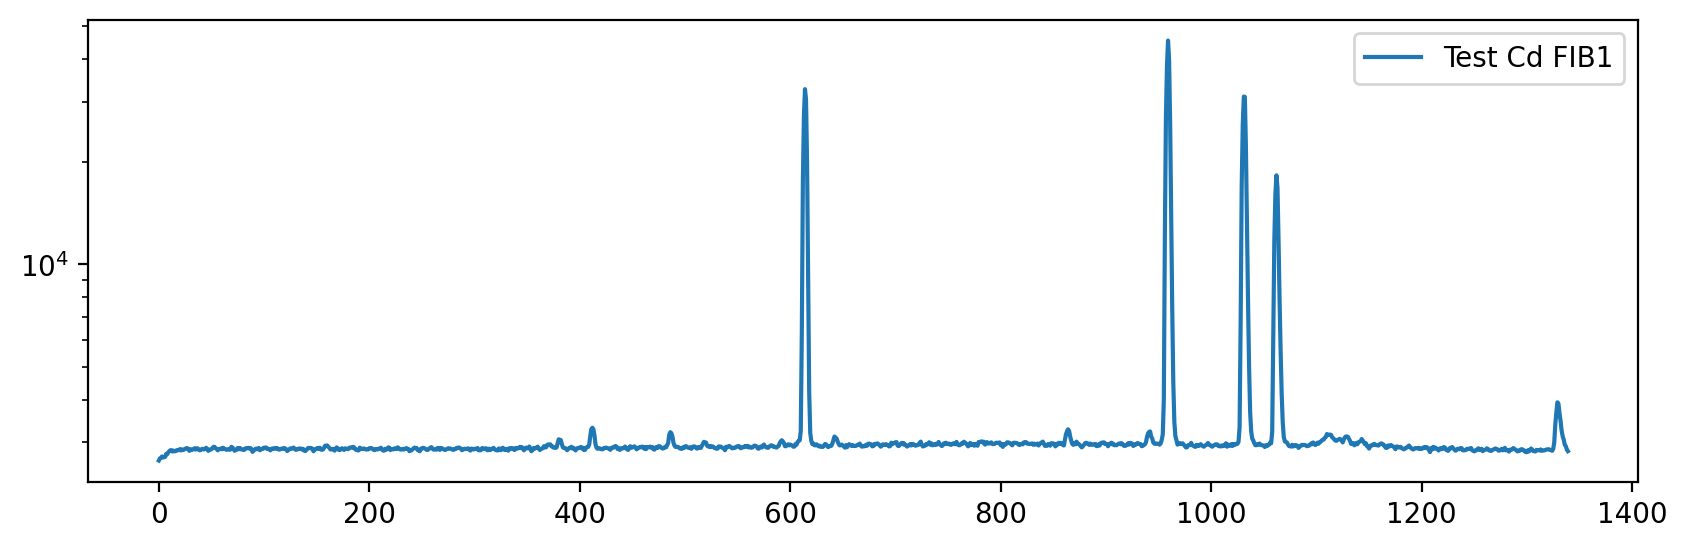

In [274]:
new_fpath = TESTDIR / "hgcd 2025-12-24_converted.fits"
fpath_im = new_fpath.parent / (new_fpath.stem + "_im.fits")
fpath_ex = new_fpath.parent / (new_fpath.stem + "_ex.fits")

hdul = fits.open(fpath_ex)
hdul.info()
tlm_hdul = fits.open(fpath_tlm)
wavela = tlm_hdul[1].data[0]


fig = plt.figure(figsize=(10, 3))
ax = fig.add_subplot(111)
# ax.imshow(hdul[0].data, cmap='gray', origin='lower')
# ax.set_xlim(800, 900)
ax.plot(hdul[0].data[0], label="Test Cd FIB1")
ax.set_yscale("log")
ax.legend()
plt.show()

cd_f1 = hdul[0].data[0][::-1]

In [275]:
user_atl_cd = np.array([
3610.05,
3612.873,
3650.15,
3654.8,
4046.8,
4358.2,
4678.2,
4799.9,
5085.8,
5460.7,
5769.6,
5790.7,
6438.5,
6965.430,
7147.041,
7383.980,
7503.867,
7514.651,
7635.105,
7948.175,
8103.692,
8115.311,
8264.521,
8424.647,
8521.441,])
user_atl_cd = np.array([
3610.05,
3612.873,
3650.15,
3654.8,
4046.8,
4358.33,
4678.16,
4799.92,
5085.82,
5460.74,
5769.60,
5790.66,
6438.47,
6965.430,
7147.041,
7383.980,
7503.867,
7514.651,
7635.105,
7948.175,
8103.692,
8115.311,
8264.521,
8424.647,
8521.441,])

In [276]:
import numpy as np
import plotly.graph_objects as go

def to_native_float(a):
    a = np.asarray(a)

    if a.dtype.byteorder not in ("=", "|"):
        a = a.byteswap().view(a.dtype.newbyteorder("="))

    return np.ascontiguousarray(a, dtype=np.float64)

# Convert arrays for Plotly (native endian)
x = to_native_float(solx)
y2 = to_native_float(cd_f1)

fig = go.Figure()
fig.add_trace(go.Scatter(x=x, y=y2, mode="lines", name="Test HgAr FIB1"))

peaks, _ = find_peaks(kr_f1, height=1000, width=(0, 15), prominence=500)
peaks = refine_peaks(kr_f1, peaks, window_width=5)

ymin = np.nanmin(y1[y1 > 0])
ymax = np.nanmax(y1)

for p in peaks:
    xp = float(x[int(p)])

    fig.add_trace(
        go.Scatter(
            x=[xp, xp],
            y=[ymin, ymax],
            mode="lines",
            line=dict(color="black", width=0.5, dash="dash"),
            hovertemplate=(
                "Peak<br>"
                f"pixel = {p:.2f}<br>"
                "λ = %{x:.2f}<br>"
                "<extra></extra>"
            ),
            showlegend=False
        )
    )

for line in user_atl_cd:
    lam = float(line)
    fig.add_trace(
        go.Scatter(
            x=[lam, lam],
            y=[ymin, ymax],
            mode="lines",
            line=dict(color="red", width=0.5),
            hovertemplate=(
                "Cd line<br>"
                "λ = %{x:.2f}<br>"
                "<extra></extra>"
            ),
            showlegend=False
        )
    )
for line in user_atl_cd:
    lam = float(line) * 2
    fig.add_trace(
        go.Scatter(
            x=[lam, lam],
            y=[ymin, ymax],
            mode="lines",
            line=dict(color="yellow", width=0.5),
            hovertemplate=(
                "Cd 2rd line<br>"
                "λ = %{x:.2f}<br>"
                "<extra></extra>"
            ),
            showlegend=False
        )
    )

fig.update_layout(
    width=1000,
    height=300,
    yaxis_type="log",
    xaxis_range=[3500, 9000],
    margin=dict(l=60, r=20, t=40, b=40),
    legend=dict(orientation="h", y=1.02, x=1, xanchor="right", yanchor="bottom"),
)

fig.show()

In [277]:
from kspecdr.extract.reduce_arc import reduce_arc

# Assuming you have an extracted arc file or run full reduction
hg_args = {
    'RAW_FILENAME': (TESTDIR / 'Hg_150_620_converted.fits').as_posix(),
    'IMAGE_FILENAME': (TESTDIR / 'Hg_150_620_converted_im.fits').as_posix(),
    'TLMAP_FILENAME': fpath_tlm.as_posix(),
    'EXTRAC_FILENAME': (TESTDIR / 'Hg_150_620_converted_ex.fits').as_posix(),
    'OUTPUT_FILENAME': (TESTDIR / 'Hg_150_620_converted_red.fits').as_posix(),
    'USE_GENCAL': True,
    'ARCDIR': WD/"data"/"arc_tables",
    'LAMPNAME': 'hgar',
}

reduce_arc(hg_args)

INFO:kspecdr.io.image:Opened file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/Hg_150_620_converted_red.fits (mode: UPDATE)
INFO:kspecdr.extract.reduce_arc:Using Generic/TAIPAN Calibration Method
INFO:kspecdr.wavecal.arc_io:Reading arc file /data1/hbahk/kspec/kspecdr/data/arc_tables/hgar.arc
INFO:kspecdr.wavecal.arc_io:Read 6 arc lines from /data1/hbahk/kspec/kspecdr/data/arc_tables/hgar.arc
INFO:kspecdr.io.image:Closed file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/Hg_150_620_converted_red.fits


TypeError: calibrate_spectral_axes() takes 10 positional arguments but 11 were given

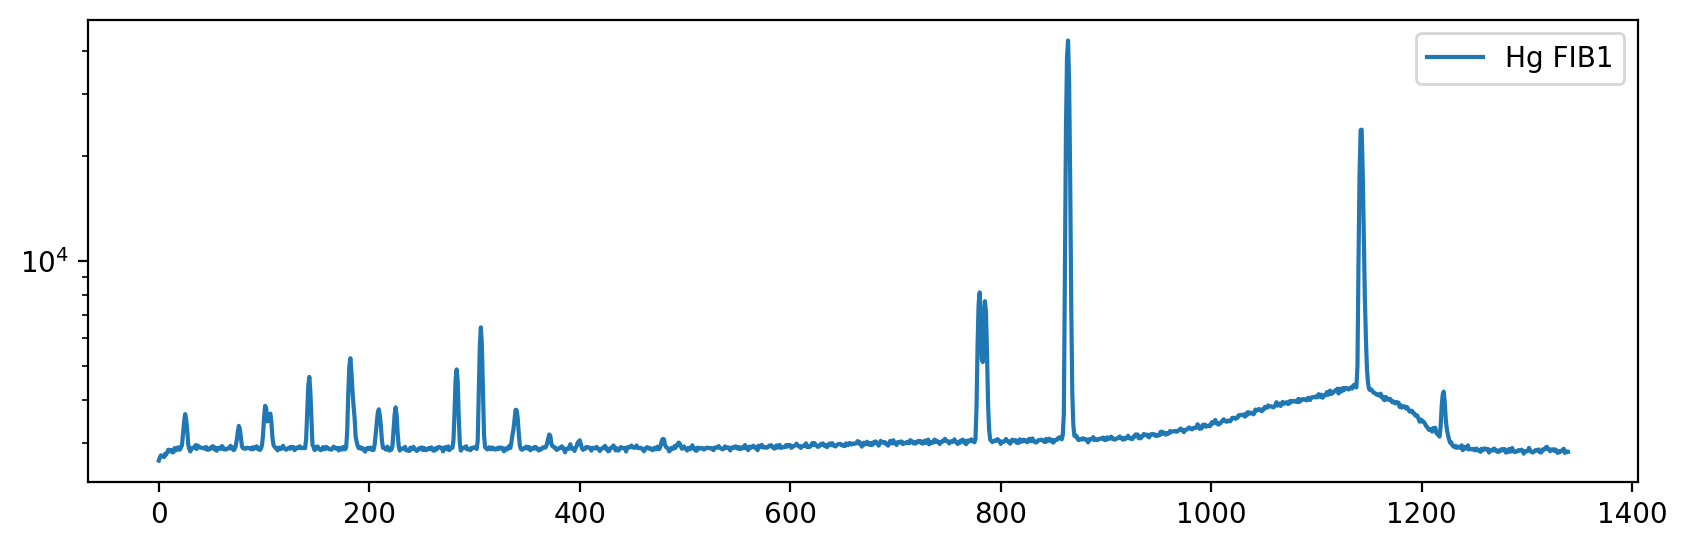

In [ ]:
hdul_hg = fits.open(hg_args['OUTPUT_FILENAME'])

fig = plt.figure(figsize=(10, 3))
ax = fig.add_subplot(111)
ax.plot(hdul_hg[0].data[0], label="Hg FIB1")
ax.set_yscale("log")
ax.legend()

In [ ]:
hdul_hg.info()

Filename: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/Hg_150_620_converted_red.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     171   (1340, 16)   float32   
  1  VARIANCE      1 ImageHDU         8   (1340, 16)   float32   


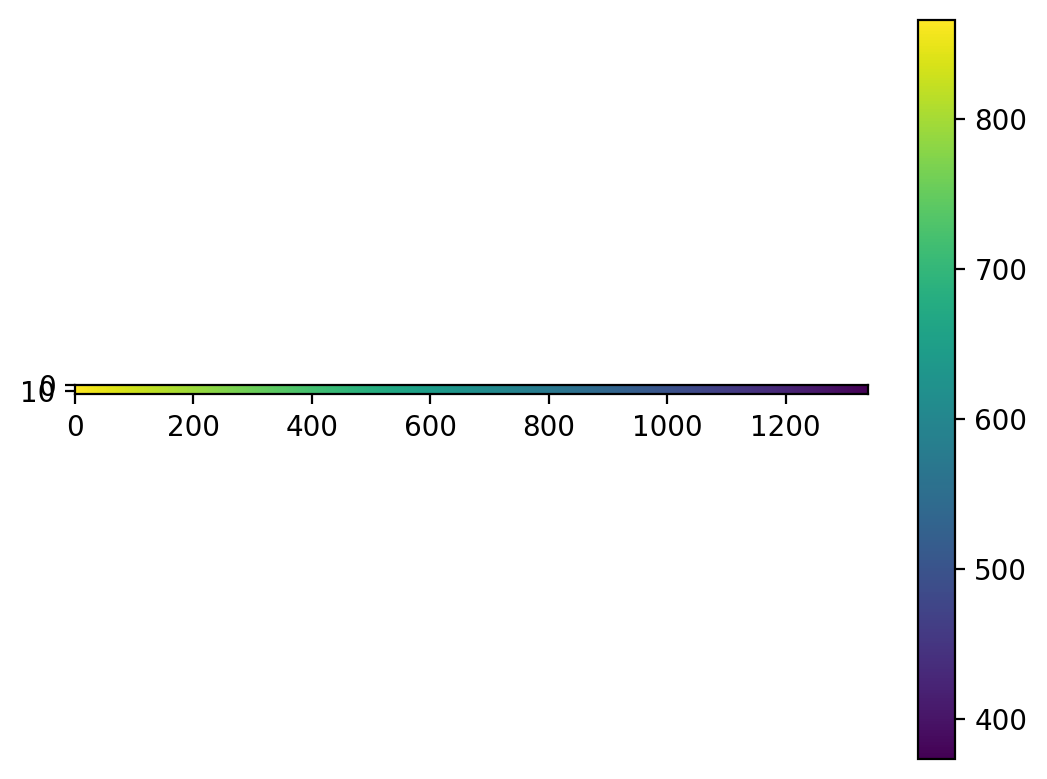

In [ ]:
hdul_tlm = fits.open(fpath_tlm)
plt.imshow(hdul_tlm[1].data)
plt.colorbar()
plt.show()


In [ ]:
pix2lam

array([3734.4 , 3738.08, 3741.76, ..., 8654.56, 8658.24, 8661.92],
      shape=(1340,))